## **Sumário Geral da Etapa de Modelagem**

Nesta segunda fase do projeto, focamos na construção de modelos de Machine Learning com o objetivo de prever a evasão de alunos nos primeiros 30 dias. Partimos do conjunto de dados tratado e enriquecido na Análise Exploratória de Dados (EDA).

---
###  Preparativos Essenciais para a Modelagem

1.  **Carregamento dos Dados Tratados:** Iniciamos carregando o dataset final da EDA, que já incluía limpezas, tratamento de outliers e todas as traduções para o português.
2.  **Definição das Features (`X`) e do Alvo (`y`):**
    * A coluna `evadiu_30_dias` foi definida como nossa variável alvo (`y`).
    * As demais colunas (exceto `student_id`) foram selecionadas como features preditoras (`X`).
3.  **Transformação da Variável Alvo:** A variável alvo `y` foi convertida de seu formato textual ("Evadiu", "Não Evadiu") para numérico (1 para "Evadiu", 0 para "Não Evadiu"), essencial para os algoritmos.
4.  **Codificação de Features Categóricas:** As features em `X` que eram textuais (como `genero`, `nivel_educacional`, `categoria_curso`, etc.) foram transformadas em formato numérico usando **One-Hot Encoding**. Isso resultou em um conjunto de features `X_encoded` com 24 colunas.
5.  **Divisão em Treino e Teste:** O conjunto de dados (`X_encoded`, `y`) foi dividido em 80% para treino e 20% para teste, utilizando **estratificação** para manter a proporção original das classes da variável alvo em ambos os conjuntos.
6.  **Escalonamento de Features:** As features numéricas originais nos conjuntos de treino e teste (`X_train`, `X_test`) foram escalonadas usando `StandardScaler` (resultando em `X_train_scaled` e `X_test_scaled`) para garantir que todas tivessem uma escala comparável, beneficiando algoritmos sensíveis a isso.

---
###  Lidando com o Desbalanceamento de Classes

A análise da variável alvo revelou um desbalanceamento significativo (84.2% "Não Evadiu" vs. 15.8% "Evadiu"). Para mitigar o impacto disso no treinamento dos modelos:
* A principal estratégia adotada foi o uso da técnica **SMOTE (Synthetic Minority Over-sampling Technique)** no conjunto de treino (`X_train_scaled`, `y_train`). Isso criou um conjunto de treino balanceado (`X_train_resampled`, `y_train_resampled`) com proporções iguais de ambas as classes.
* Também foi realizado um experimento com o LightGBM utilizando seu parâmetro interno `scale_pos_weight` nos dados de treino desbalanceados.

---
### Modelos Testados e Avaliação

Foram treinados e avaliados os seguintes algoritmos de classificação, conforme sugerido no desafio:
1.  **Regressão Logística** (com dados SMOTE)
2.  **Árvore de Decisão** (com parâmetros padrão, usando dados SMOTE)
3.  **LightGBM** (com parâmetros padrão, usando dados SMOTE)
4.  **LightGBM Ajustado (Tuned)** (com hiperparâmetros otimizados via `GridSearchCV`, usando dados SMOTE)
5.  **LightGBM com `scale_pos_weight`** (usando dados de treino originais desbalanceados)
6.  **KNN (K-Nearest Neighbors)** (com `k` otimizado via `GridSearchCV`, usando dados SMOTE)

A avaliação dos modelos no conjunto de teste focou em métricas como Recall, Precisão e F1-Score para a classe "Evadiu (1)", além do AUC-ROC e Acurácia Geral.

---
###  Comparação e Escolha do Melhor Modelo

Uma tabela comparativa consolidou o desempenho dos modelos:

| Modelo                                  | Recall (Evadiu) | Precisão (Evadiu) | F1-Score (Evadiu) | AUC-ROC | Acurácia Geral | TP | FP |
| :-------------------------------------- | :-------------- | :----------------- | :---------------- | :------ | :------------- | :- | :- |
| Regressão Logística (SMOTE)             | 0.00            | 0.00               | 0.00              | 0.5871  | 0.83           | 0  | 1  |
| Árvore de Decisão (Padrão, SMOTE)       | 0.25            | 0.27               | 0.26              | 0.5595  | 0.77           | 4  | 11 |
| LightGBM (Padrão, SMOTE)              | 0.19            | 0.75               | 0.30              | 0.5528  | 0.86           | 3  | 1  |
| **LightGBM (Ajustado, SMOTE, Th=0.4192)** | **0.25** | **0.67** | **0.36** | **0.5990**| **0.86** | **4**| **2**|
| LightGBM (scale_pos_weight)             | 0.25            | 0.33               | 0.29              | 0.4963  | 0.80           | 4  | 8  |
| KNN (k=5, SMOTE)                        | 0.25            | 0.14               | 0.18              | 0.5353  | 0.63           | 4  | 25 |

O modelo **`LightGBM (Ajustado, SMOTE, Th=0.4192)`** foi selecionado como o melhor devido ao seu **AUC-ROC de 0.5990** (o mais alto entre os testados) e o **maior F1-Score para a classe "Evadiu" (0.36)**. Ele alcançou um Recall de 0.25 (identificando 4 dos 16 alunos que evadiram) com uma Precisão de 0.67 (2 Falsos Positivos).

---
### Otimização do Threshold de Classificação

Para o modelo LightGBM ajustado, foi realizada uma análise do threshold de classificação. Verificou-se que, embora diminuir o threshold pudesse (em teoria) aumentar o Recall, para este modelo específico, o Recall máximo para "Evadiu" de 0.25 foi atingido com um threshold de **0.4192**. Este threshold também maximizou o F1-Score (0.36) para a classe "Evadiu", oferecendo a melhor Precisão (0.67) para esse nível de Recall. Baixar mais o threshold não aumentou o número de evasões reais identificadas, apenas aumentou os falsos positivos.

---
### Interpretabilidade do Modelo Escolhido (LightGBM Ajustado)

* **Importância das Features (LightGBM):** As análises de importância de features indicaram que `media_minutos_por_sessao`, `total_sessoes`, e `idade` foram consistentemente as mais influentes para o modelo LightGBM.
* **Análise SHAP:** A análise com SHAP (SHapley Additive exPlanations) forneceu uma visão mais profunda de como cada característica contribui para as previsões individuais. Por exemplo (com base nos gráficos SHAP gerados):
    * _Valores baixos de `total_sessoes` tendem a aumentar a probabilidade de evasão, enquanto valores altos a diminuem._
    * _A `media_minutos_por_sessao` também mostrou um impacto significativo, onde [descreva a tendência observada no seu gráfico SHAP de dependência, ex: valores mais altos diminuem a chance de evasão]._
    * _A `idade` também influenciou as previsões, com [descreva a tendência observada no seu gráfico SHAP de dependência]._
    *(Adapte as interpretações SHAP com base nos seus gráficos específicos).*

---
### Desempenho Final e Limitações do Modelo

O modelo final escolhido (`LightGBM Ajustado, SMOTE, com threshold de 0.4192`) apresentou o seguinte desempenho no conjunto de teste:
* **Recall para "Evadiu": 0.25** (Identifica 1 a cada 4 alunos que realmente evadem).
* **Precisão para "Evadiu": 0.67** (Quando prevê evasão, está correto em 2 de cada 3 vezes, aproximadamente).
* **F1-Score para "Evadiu": 0.36**.
* **AUC-ROC: 0.5990**.

**Principais Limitações:**
* O modelo ainda **não consegue identificar a maioria dos alunos que evadirão** (75% dos casos de evasão não são detectados - Falsos Negativos).
* Embora a precisão para os casos de evasão detectados seja razoável (67%), ainda haverá **alarmes falsos** (Falsos Positivos).
* A capacidade geral de discriminação do modelo (AUC-ROC próximo de 0.60) é modesta.


# **Construindo o Modelo para Prever a Evasão**

Segunda etapa do Desafio.

Na Etapa Anterior (01_Analise_Exploratoria_Evasao), nós limpamos, tratamos e exploramos os dados dos alunos para entender melhor suas características e os padrões iniciais de evasão.

Agora, vamos usar esse conhecimento e os dados preparados para construir e treinar **modelos de Machine Learning**. O objetivo desses modelos é aprender com os dados históricos para tentar prever quais novos alunos têm maior risco de evadir do curso nos primeiros 30 dias.

## **Preapração do Ambiente**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas do Scikit-learn para pré-processamento e modelagem
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

# Algoritmos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import lightgbm as lgb

import shap

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
caminho_df_final_tratado = '/content/drive/MyDrive/desafio_viitra/edtech_dropout_dataset_tratado.csv'

### **Visualização do Arquivo Tratado**

In [ ]:
try:
    df_modelagem = pd.read_csv(caminho_df_final_tratado)
    print(f"DataFrame '{caminho_df_final_tratado}' carregado com sucesso para 'df_modelagem'.")
    print(f"Dimensões do DataFrame carregado: {df_modelagem.shape}")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{caminho_df_final_tratado}' não encontrado.")
    df_modelagem = None # Define como None se não encontrar
except Exception as e:
    print(f"ERRO ao carregar o DataFrame: {e}")
    df_modelagem = None # Define como None em caso de outro erro

# Verifica se o DataFrame foi carregado
if df_modelagem is not None:
    print("\nPrimeiras 5 linhas do DataFrame carregado:")
    print(df_modelagem.head())
    print("\nInformações do DataFrame carregado:")
    df_modelagem.info()
    print("\nVerificação de valores ausentes no DataFrame carregado:")
    print(df_modelagem.isnull().sum())

DataFrame '/content/drive/MyDrive/desafio_viitra/edtech_dropout_dataset_tratado.csv' carregado com sucesso para 'df_modelagem'.
Dimensões do DataFrame carregado: (500, 14)

Primeiras 5 linhas do DataFrame carregado:
  student_id  idade     genero nivel_educacional categoria_curso  \
0      S0000     54   Feminino   Pós-graduado(a)          Design   
1      S0001     44   Feminino     Não Informado      Tecnologia   
2      S0002     30  Masculino   Pós-graduado(a)         Idiomas   
3      S0003     58      Outro   Pós-graduado(a)        Negócios   
4      S0004     23  Masculino   Pós-graduado(a)        Negócios   

   dias_ativo_primeira_semana  media_minutos_por_sessao  total_sessoes  \
0                           6                     49.66             27   
1                           5                      2.07             23   
2                           0                     19.45             27   
3                           2                     57.27              5   
4    

### **Dados Prontos para a Modelagem**

O resultado acima confirma que nosso conjunto de dados tratado foi carregado com sucesso! Temos:
* **500 alunos (linhas) e 14 características (colunas)**, todas em português e com os valores que ajustamos na etapa anterior.
* Uma amostra das primeiras linhas (`Primeiras 5 linhas...`) nos mostra os dados como esperado.
* As informações gerais (`Informações do DataFrame carregado...`) mostram que todas as colunas estão completas (**sem valores ausentes**), e os tipos de dados estão corretos para esta fase (alguns como números inteiros - `int64`, um como número decimal - `float64` para `media_minutos_por_sessao`, e outros como texto - `object` para as categorias que traduzimos).

Com essa base de dados limpa e organizada, podemos começar a prepará-la especificamente para os modelos de Machine Learning. O primeiro passo é separar claramente quais informações usaremos para fazer as previsões (as "features" ou características) e qual informação queremos prever (a "variável alvo", que é a evasão).

## **Preparando `X` e `y`**

Com nosso conjunto de dados (`df_modelagem`) carregado e verificado, o próximo passo crucial na preparação para a modelagem é separar claramente:
1.  As **características (features ou `X`)** que usaremos para ensinar o modelo. Estas são todas as colunas de informação sobre os alunos que podem nos dar pistas sobre a evasão (ex: idade, nível educacional, atividade na plataforma), excluindo o `student_id` (que é apenas um identificador) e a própria coluna de evasão.
2.  A **variável alvo (`y`)** que queremos que o modelo aprenda a prever. No nosso caso, é a coluna `evadiu_30_dias`.

Além disso, como os modelos de machine learning trabalham com números, precisamos converter nossa variável alvo, que estava com os textos "Evadiu" e "Não Evadiu", de volta para um formato numérico.

**O que o código faz:**
* Cria um conjunto de dados `X` contendo todas as colunas, exceto `student_id` e `evadiu_30_dias`.
* Cria uma variável `y_text` que guarda a coluna `evadiu_30_dias` com os textos originais (para referência).
* Cria a variável alvo final `y` convertendo:
    * "Evadiu" para o número **1**.
    * "Não Evadiu" para o número **0**.
* Verifica se a conversão foi bem-sucedida e mostra uma amostra de `X` e `y`.



In [ ]:
# 1. Definir Features (X) e Variável Alvo (y_text)
# 'student_id' não é uma feature preditiva e 'evadiu_30_dias' é o nosso alvo.
if 'student_id' in df_modelagem.columns and 'evadiu_30_dias' in df_modelagem.columns:
    X = df_modelagem.drop(columns=['student_id', 'evadiu_30_dias'])
    y_text = df_modelagem['evadiu_30_dias'] # Mantemos a versão em texto para referência, se necessário
    print("Features (X) e Variável Alvo (y_text) definidas.")
else:
    print("ERRO: Coluna 'student_id' ou 'evadiu_30_dias' não encontrada no df_modelagem.")

# 2. Converter a Variável Alvo (y_text) para Formato Numérico
mapa_alvo_numerico = {
    "Evadiu": 1,
    "Não Evadiu": 0
}
# Aplicar o mapeamento para criar a variável y numérica
y = y_text.map(mapa_alvo_numerico)

print("\nVariável alvo convertida para formato numérico (y):")
print(y.value_counts())

# Verificar se o mapeamento foi bem-sucedido e não gerou NaNs em y
if y.isnull().sum() > 0:
    print(f"\nATENÇÃO: Foram encontrados {y.isnull().sum()} valores NaN em 'y' após o mapeamento!")
else:
    print("\nConversão da variável alvo 'y' para numérico bem-sucedida e sem NaNs.")

print("\nPrimeiras 5 linhas de X (features):")
print(X.head())
print("\nPrimeiros 5 valores de y (alvo numérico):")
print(y.head())
print(f"\nTipo de dado de y: {y.dtype}")

Features (X) e Variável Alvo (y_text) definidas.

Variável alvo convertida para formato numérico (y):
evadiu_30_dias
0    421
1     79
Name: count, dtype: int64

Conversão da variável alvo 'y' para numérico bem-sucedida e sem NaNs.

Primeiras 5 linhas de X (features):
   idade     genero nivel_educacional categoria_curso  \
0     54   Feminino   Pós-graduado(a)          Design   
1     44   Feminino     Não Informado      Tecnologia   
2     30  Masculino   Pós-graduado(a)         Idiomas   
3     58      Outro   Pós-graduado(a)        Negócios   
4     23  Masculino   Pós-graduado(a)        Negócios   

   dias_ativo_primeira_semana  media_minutos_por_sessao  total_sessoes  \
0                           6                     49.66             27   
1                           5                      2.07             23   
2                           0                     19.45             27   
3                           2                     57.27              5   
4                 

O output confirma que a separação foi feita e que nossa variável alvo `y` agora contém 421 instâncias da classe 0 (Não Evadiu) e 79 instâncias da classe 1 (Evadiu). A conversão para números foi um sucesso e não gerou dados faltantes.


## **Convertendo Texto em Números: One-Hot Encoding das Características Categóricas**

No passo anterior, separamos nossas "features" (`X`) da nossa "variável alvo" (`y`) e garantimos que `y` estivesse em formato numérico (0s e 1s). Agora, precisamos fazer o mesmo para as colunas em `X` que ainda contêm texto, como `genero`, `nivel_educacional`, `categoria_curso`, etc.

A maioria dos algoritmos de Machine Learning não consegue processar texto diretamente; eles precisam de números. Para converter essas colunas de texto em um formato numérico que os modelos entendam, usamos uma técnica chamada **One-Hot Encoding**.

**Como funciona o One-Hot Encoding?**
Imagine a coluna `genero`, que tem as categorias "Feminino", "Masculino" e "Outro". O One-Hot Encoding transformará essa única coluna em três novas colunas:
* `genero_Feminino`: Terá o valor 1 se o aluno for do gênero Feminino, e 0 caso contrário.
* `genero_Masculino`: Terá o valor 1 se o aluno for do gênero Masculino, e 0 caso contrário.
* `genero_Outro`: Terá o valor 1 se o aluno for do gênero Outro, e 0 caso contrário.
Isso é feito para cada categoria de cada coluna de texto que temos. As colunas que já são numéricas (como `idade`, `total_sessoes`) não são alteradas por este processo.

O código a seguir identifica as colunas de texto em `X` e aplica o One-Hot Encoding nelas.

In [ ]:
# Identificar colunas categóricas em X (são as do tipo 'object')
colunas_categoricas_em_X = X.select_dtypes(include=['object']).columns
print(f"Colunas categóricas em X para One-Hot Encoding: {colunas_categoricas_em_X.tolist()}")

# drop_first=True pode ser usado para evitar multicolinearidade,
# Vamos manter todas as dummies por enquanto para maior interpretabilidade inicial das features.
X_encoded = pd.get_dummies(X, columns=colunas_categoricas_em_X, prefix=colunas_categoricas_em_X)

print("\nDataFrame X após One-Hot Encoding:")
print(f"Novas dimensões de X_encoded: {X_encoded.shape}")
print("Primeiras 5 linhas de X_encoded:")
print(X_encoded.head())
print("\nTipos de dados em X_encoded:")
X_encoded.info()

Colunas categóricas em X para One-Hot Encoding: ['genero', 'nivel_educacional', 'categoria_curso', 'concluiu_primeiro_quiz', 'tipo_assinatura', 'tipo_dispositivo']

DataFrame X após One-Hot Encoding:
Novas dimensões de X_encoded: (500, 24)
Primeiras 5 linhas de X_encoded:
   idade  dias_ativo_primeira_semana  media_minutos_por_sessao  total_sessoes  \
0     54                           6                     49.66             27   
1     44                           5                      2.07             23   
2     30                           0                     19.45             27   
3     58                           2                     57.27              5   
4     23                           0                     29.54             25   

   posts_forum  mensagens_tutor  genero_Feminino  genero_Masculino  \
0            1                0             True             False   
1            1                0             True             False   
2            0                

*O resumo técnico (`X_encoded.info()`) confirma que todas as 24 colunas agora são de tipos numéricos (`int64` para inteiros, `float64` para decimais, e `bool` para as novas colunas do One-Hot Encoding, que são tratadas como 0/1). Não há mais colunas de texto (`object`).*


## **Preparando o Terreno para Treinamento e Teste dos Modelos**

Com nossas "features" (`X_encoded`) e nossa "variável alvo" (`y`) totalmente em formato numérico, o próximo passo é dividir nosso conjunto de dados principal em duas partes distintas:

1.  **Conjunto de Treino:** Será a maior parte dos dados (normalmente 70-80%). Usaremos este conjunto para "ensinar" os nossos modelos de Machine Learning. É como dar o material de estudo para os modelos aprenderem os padrões.
2.  **Conjunto de Teste:** Uma porção menor dos dados (os 20-30% restantes) que será guardada e não mostrada aos modelos durante o treinamento. Usaremos este conjunto no final para ver o quão bem os modelos aprenderam e se conseguem fazer previsões corretas em dados que nunca viram antes. É como aplicar uma "prova" para os modelos.

**Por que dividir?**
Essa divisão é crucial para avaliar de forma honesta se o modelo realmente aprendeu ou se apenas "decorou" os dados de treino (o que chamamos de "overfitting").

**Consideração Importante: Estratificação**
Lembram que nossa variável alvo (`evadiu_30_dias`) é desbalanceada (temos muito mais alunos que "Não Evadiram" do que os que "Evadiram")? Ao dividir os dados, é importante que essa proporção seja mantida tanto no conjunto de treino quanto no de teste. O código abaixo usa uma técnica chamada **estratificação** (`stratify=y`) para garantir exatamente isso.

O código a seguir realiza essa divisão.

In [ ]:
# X_encoded contém nossas features totalmente numéricas
# y contém nossa variável alvo numérica (0 ou 1)

# Dividir os dados: 80% para treino, 20% para teste
# test_size=0.2 define a proporção do conjunto de teste
# random_state=42 garante que a divisão seja a mesma toda vez que o código rodar (para reprodutibilidade)
# stratify=y garante que a proporção das classes da variável alvo seja mantida em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print("Divisão dos dados concluída.")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de y_test: {y_test.shape}")

print("\nDistribuição da variável alvo no conjunto de treino (y_train):")
print(y_train.value_counts(normalize=True))

print("\nDistribuição da variável alvo no conjunto de teste (y_test):")
print(y_test.value_counts(normalize=True))

Divisão dos dados concluída.
Formato de X_train: (400, 24)
Formato de X_test: (100, 24)
Formato de y_train: (400,)
Formato de y_test: (100,)

Distribuição da variável alvo no conjunto de treino (y_train):
evadiu_30_dias
0    0.8425
1    0.1575
Name: proportion, dtype: float64

Distribuição da variável alvo no conjunto de teste (y_test):
evadiu_30_dias
0    0.84
1    0.16
Name: proportion, dtype: float64


* **Sucesso na Estratificação!** Observe como a porcentagem de alunos que "Evadiram" (classe 1) é muito similar em ambos os conjuntos:
    * No conjunto de treino: **15.75%** evadiram.
    * No conjunto de teste: **16.00%** evadiram.
* A porcentagem de alunos que "Não Evadiram" (classe 0) também é muito parecida (84.25% no treino vs. 84% no teste).
* Isso nos mostra que a divisão estratificada funcionou bem, garantindo que os dois conjuntos sejam representativos da distribuição original do nosso problema de evasão.

Com os dados agora divididos de forma adequada, estamos prontos para a próxima etapa de pré-processamento antes de, finalmente, treinar nossos modelos: o escalonamento das features numéricas.

## **Escalonamento das Características Numéricas**

Depois de dividirmos nossos dados em conjuntos de treino e teste, e antes de alimentá-los aos modelos, há mais um passo importante para as características numéricas: o **escalonamento**.

**Por que escalonar?**
Imagine que temos uma característica como `idade` (com valores de, digamos, 16 a 59) e outra como `posts_forum` (com valores de 0 a 3, após o capping). Alguns algoritmos de Machine Learning, especialmente aqueles que calculam "distâncias" entre os alunos (como o KNN) ou que usam técnicas de otimização sensíveis à escala (como a Regressão Logística), podem dar mais importância indevida às características com valores maiores, simplesmente por causa da magnitude desses números, e não por sua real importância para prever a evasão.

O escalonamento resolve isso, colocando todas as nossas características numéricas em uma **escala comum**, sem distorcer as diferenças nos intervalos de valores. Uma técnica comum é a **Padronização (StandardScaler)**, que transforma os dados para que cada característica numérica tenha uma média de 0 e um desvio padrão de 1.

**O que o código faz:**
1.  Identifica quais colunas em nossos dados de treino e teste são as numéricas originais (excluindo as que foram criadas pelo One-Hot Encoding, que já são 0 ou 1).
2.  Cria cópias dos nossos conjuntos de treino e teste (`X_train_scaled` e `X_test_scaled`) para não modificar os originais.
3.  Utiliza uma ferramenta chamada `StandardScaler`:
    * Primeiro, o `StandardScaler` "aprende" a média e o desvio padrão de cada característica numérica **apenas** no conjunto de treino (`X_train`). Isso é muito importante para evitar "vazamento de dados" do conjunto de teste.
    * Depois, ele usa essas médias e desvios padrão aprendidos para transformar (escalonar) tanto o conjunto de treino (`X_train`) quanto o conjunto de teste (`X_test`).


In [ ]:
# Identificar as colunas numéricas originais (não as criadas pelo One-Hot Encoding)
# ou as que eram int/float em X_encoded antes de se tornarem bool após OHE (se aplicável, mas X_encoded.info() mostrou as OHE como bool)

# Vamos pegar os nomes das colunas originais que eram numéricas em X (antes do OHE)
# As colunas booleanas (resultado do get_dummies) não precisam ser escalonadas.
colunas_numericas_originais = X.select_dtypes(include=np.number).columns.tolist()

print(f"Colunas numéricas originais para escalonamento: {colunas_numericas_originais}")

# Criar uma cópia dos DataFrames de treino e teste para aplicar o escalonamento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Inicializar o StandardScaler
scaler = StandardScaler()

# Ajustar o scaler APENAS nos dados de treino e transformar X_train
X_train_scaled[colunas_numericas_originais] = scaler.fit_transform(X_train[colunas_numericas_originais])

# Usar o scaler JÁ AJUSTADO para transformar X_test
X_test_scaled[colunas_numericas_originais] = scaler.transform(X_test[colunas_numericas_originais])

print("\nEscalonamento das features numéricas concluído.")
print("Primeiras 5 linhas de X_train_scaled (apenas colunas numéricas originais para conferência):")
print(X_train_scaled[colunas_numericas_originais].head())

print("\nPrimeiras 5 linhas de X_test_scaled (apenas colunas numéricas originais para conferência):")
print(X_test_scaled[colunas_numericas_originais].head())

# Verificar a média e o desvio padrão das colunas escalonadas em X_train_scaled
print("\nApós escalonamento, média das colunas numéricas em X_train_scaled (deve ser próxima de 0):")
print(X_train_scaled[colunas_numericas_originais].mean())
print("\nApós escalonamento, desvio padrão das colunas numéricas em X_train_scaled (deve ser próximo de 1):")
print(X_train_scaled[colunas_numericas_originais].std())

Colunas numéricas originais para escalonamento: ['idade', 'dias_ativo_primeira_semana', 'media_minutos_por_sessao', 'total_sessoes', 'posts_forum', 'mensagens_tutor']

Escalonamento das features numéricas concluído.
Primeiras 5 linhas de X_train_scaled (apenas colunas numéricas originais para conferência):
        idade  dias_ativo_primeira_semana  media_minutos_por_sessao  \
73  -1.179028                    0.265536                  1.623722   
80   0.068002                   -0.627021                 -0.396115   
487  0.613578                   -0.180743                  1.136890   
301 -0.087877                    1.604371                 -0.888431   
335  0.769457                   -1.519578                  1.673076   

     total_sessoes  posts_forum  mensagens_tutor  
73       -1.398896    -0.167129         0.790183  
80       -0.688646    -0.167129        -0.744153  
487      -1.635646     0.830656        -0.744153  
301       1.086978     0.830656         2.324519  
335      -

*Estas verificações confirmam que o `StandardScaler` funcionou como esperado no conjunto de treino:*
* *As **médias** de todas as colunas numéricas escalonadas estão muito próximas de 0 (os valores como `1.82e-16` são números extremamente pequenos, essencialmente zero).*
* *Os **desvios padrão** estão muito próximos de 1.*


## **Técnica SMOTE**

Como vimos anteriormente, nossa variável alvo (`evadiu_30_dias`) é desbalanceada: temos muito mais alunos que "Não Evadiram" do que alunos que "Evadiram". Se treinarmos nossos modelos diretamente com esses dados desbalanceados, eles podem aprender a simplesmente prever a classe majoritária (Não Evadiu) na maioria das vezes, pois isso já lhes daria uma acurácia razoável, mas falhariam em identificar os alunos que realmente evadem (que é o nosso objetivo principal).

Para combater isso, uma das técnicas que podemos usar é o **SMOTE (Synthetic Minority Over-sampling Technique)**.

**O que o SMOTE faz?**
O SMOTE olha para os alunos da classe minoritária (os que "Evadiram") e cria novas amostras "sintéticas" (artificiais, mas realistas) que são similares a eles. Isso aumenta o número de exemplos da classe minoritária no nosso **conjunto de treino**, tornando-o mais balanceado.
**Importante:** Aplicamos o SMOTE **apenas** no conjunto de treino (`X_train_scaled`, `y_train`). O conjunto de teste (`X_test_scaled`, `y_test`) permanece com o desbalanceamento original para que possamos avaliar o modelo em um cenário mais próximo da realidade.

Após aplicar o SMOTE, usamos esses dados de treino balanceados para treinar nosso primeiro modelo: a **Regressão Logística**.


In [ ]:
# --- 1. Aplicar SMOTE ao conjunto de treino ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Dimensões de X_train após SMOTE:", X_train_resampled.shape)
print("Dimensões de y_train após SMOTE:", y_train_resampled.shape)
print("\nDistribuição da variável alvo em y_train_resampled após SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# --- 2. Treinar o Primeiro Modelo: Regressão Logística ---
# Usaremos os dados reamostrados (X_train_resampled, y_train_resampled) para treinar
log_reg = LogisticRegression(random_state=42, solver='liblinear') # solver='liblinear' é bom para datasets menores

print("\n--- Treinando Modelo: Regressão Logística ---")
log_reg.fit(X_train_resampled, y_train_resampled)
print("Treinamento da Regressão Logística concluído.")

# Fazer previsões no conjunto de teste (X_test_scaled)
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# Avaliar o modelo
print("\n--- Avaliação da Regressão Logística no Conjunto de Teste ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_log_reg):.4f}")

Dimensões de X_train após SMOTE: (674, 24)
Dimensões de y_train após SMOTE: (674,)

Distribuição da variável alvo em y_train_resampled após SMOTE:
evadiu_30_dias
0    0.5
1    0.5
Name: proportion, dtype: float64

--- Treinando Modelo: Regressão Logística ---
Treinamento da Regressão Logística concluído.

--- Avaliação da Regressão Logística no Conjunto de Teste ---
Matriz de Confusão:
[[83  1]
 [16  0]]

Relatório de Classificação:
                precision    recall  f1-score   support

Não Evadiu (0)       0.84      0.99      0.91        84
    Evadiu (1)       0.00      0.00      0.00        16

      accuracy                           0.83       100
     macro avg       0.42      0.49      0.45       100
  weighted avg       0.70      0.83      0.76       100

AUC-ROC: 0.5871


**Interpretando os Resultados da Regressão Logística:**
* **Matriz de Confusão:**
    * O modelo previu corretamente 83 alunos que "Não Evadiram".
    * Ele previu incorretamente 1 aluno como "Evadiu" (era "Não Evadiu" - Falso Positivo).
    * Crucialmente, dos 16 alunos que realmente "Evadiram" no conjunto de teste, o modelo previu **todos os 16** como "Não Evadiu" (Falsos Negativos). Ele **não identificou corretamente nenhum aluno que evadiu** (0 Verdadeiros Positivos).
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): 0.00
    * `recall` (Sensibilidade/Revocação): 0.00
    * `f1-score`: 0.00
    * *Isso significa que, para a classe de alunos que evadiram, o desempenho do modelo foi nulo. Ele não conseguiu "lembrar" ou identificar nenhum deles.*
* **Acurácia:** A acurácia geral de 83% é enganosa. Ela é alta porque o modelo acerta a maioria dos casos da classe majoritária ("Não Evadiu"), mas falha completamente em nosso objetivo principal.
* **AUC-ROC:** Um valor de 0.5871 é muito próximo de 0.5, que indica um desempenho similar a um palpite aleatório.

**Conclusão sobre este Primeiro Modelo:**
A Regressão Logística, mesmo treinada com os dados balanceados pelo SMOTE, não conseguiu aprender a identificar os alunos que evadem no conjunto de teste. Seu desempenho para a classe minoritária ("Evadiu") foi insatisfatório. Isso nos mostra que precisaremos testar outros algoritmos mais complexos ou outras abordagens para tentar capturar os padrões de evasão.

## **Árvore de Decisão**

Após nossa primeira tentativa com a Regressão Logística, que não conseguiu identificar os alunos que evadiram, vamos agora testar um modelo diferente: a **Árvore de Decisão**.

**Como funciona uma Árvore de Decisão (de forma simples)?**
Imagine um fluxograma com várias perguntas do tipo "sim" ou "não" sobre as características do aluno. Por exemplo: "O aluno teve mais de X sessões? Se sim, siga por este caminho; se não, por aquele." Ao final de uma série dessas perguntas (ramos da árvore), o modelo chega a uma "folha" que indica se o aluno provavelmente vai evadir ou não.

Assim como no modelo anterior, usamos os dados de treino que foram balanceados com a técnica SMOTE (`X_train_resampled`, `y_train_resampled`) para ensinar a Árvore de Decisão. Em seguida, vemos como ela se sai no conjunto de teste.

O código a seguir treina o modelo, faz as previsões e avalia seu desempenho. Além disso, como as Árvores de Decisão naturalmente calculam quais características foram mais "úteis" para criar suas regras, também exibimos a importância dessas características.


--- Treinando Modelo: Árvore de Decisão ---
Treinamento da Árvore de Decisão concluído.

--- Avaliação da Árvore de Decisão no Conjunto de Teste ---
Matriz de Confusão:
[[73 11]
 [12  4]]

Relatório de Classificação:
                precision    recall  f1-score   support

Não Evadiu (0)       0.86      0.87      0.86        84
    Evadiu (1)       0.27      0.25      0.26        16

      accuracy                           0.77       100
     macro avg       0.56      0.56      0.56       100
  weighted avg       0.76      0.77      0.77       100

AUC-ROC: 0.5595

--- Importância das Features (Árvore de Decisão) ---
Top 10 features mais importantes:
                                feature  importance
3                         total_sessoes    0.176003
2              media_minutos_por_sessao    0.174794
0                                 idade    0.087898
23              tipo_dispositivo_Tablet    0.080734
18  concluiu_primeiro_quiz_Não Concluiu    0.073562
1            dias_ativo_prim

<ipython-input-20-8e111d37d7bf>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


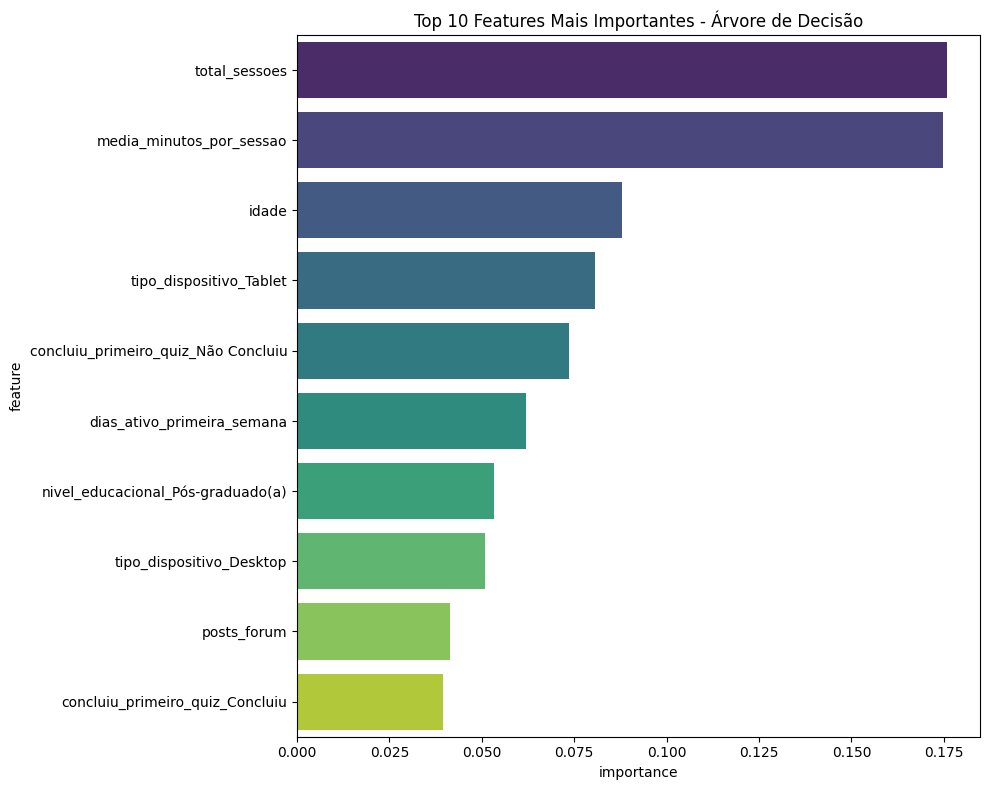

In [ ]:
# --- 1. Inicializar e Treinar o Modelo: Árvore de Decisão ---
# Usaremos os dados reamostrados (X_train_resampled, y_train_resampled) para treinar
# random_state para reprodutibilidade. Podemos adicionar max_depth para evitar overfitting.
# Ex: dt_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_clf = DecisionTreeClassifier(random_state=42)

print("--- Treinando Modelo: Árvore de Decisão ---")
dt_clf.fit(X_train_resampled, y_train_resampled)
print("Treinamento da Árvore de Decisão concluído.")

# Fazer previsões no conjunto de teste (X_test_scaled)
y_pred_dt = dt_clf.predict(X_test_scaled)
y_pred_proba_dt = dt_clf.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# --- 2. Avaliar o Modelo ---
print("\n--- Avaliação da Árvore de Decisão no Conjunto de Teste ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_dt, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

# --- 3. Importância das Features ---
# Árvores de decisão calculam a importância das features durante o treinamento
if hasattr(dt_clf, 'feature_importances_'):
    importances = dt_clf.feature_importances_
    # Criar um DataFrame para visualizar as importâncias
    # X_train_scaled é um DataFrame do Pandas e tem os nomes das colunas
    feature_names = X_train_scaled.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print("\n--- Importância das Features (Árvore de Decisão) ---")
    print("Top 10 features mais importantes:")
    print(feature_importance_df.head(10))

    # Plotar a importância das features (Top N)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Features Mais Importantes - Árvore de Decisão')
    plt.tight_layout()
    plt.show()

**Interpretando os Resultados da Árvore de Decisão:**
* **Matriz de Confusão:**
    * Desta vez, o modelo conseguiu identificar **4 alunos que realmente evadiram** (Verdadeiros Positivos). Isso é uma melhora significativa em relação à Regressão Logística, que não identificou nenhum!
    * No entanto, ele ainda deixou de identificar **12 alunos** que evadiram (Falsos Negativos).
    * E classificou incorretamente **11 alunos** como "Evadiu" quando eles não evadiram (Falsos Positivos).
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): 0.27 (Quando a Árvore diz que um aluno vai evadir, ela acerta em 27% das vezes).
    * `recall` (Sensibilidade/Revocação): 0.25 (A Árvore conseguiu encontrar **25%** de todos os alunos que realmente evadiram no conjunto de teste).
    * `f1-score`: 0.26
* **Acurácia:** A acurácia geral foi de 77%.
* **AUC-ROC:** O valor de 0.5595 ainda é baixo, indicando uma capacidade de discriminação geral fraca, mas ligeiramente melhor que um palpite aleatório.

**Comparativo:** A Árvore de Decisão, mesmo com parâmetros padrão, já mostrou uma capacidade (ainda que modesta) de identificar alguns alunos em risco de evasão, ao contrário da Regressão Logística. O Recall de 25% para a classe "Evadiu" é um avanço, embora ainda precisemos melhorá-lo.

**Gráfico**
É possível perceber que `total_sessoes`, `media_minutos_por_sessao` e `idade` estão entre as mais relevantes, seguidas por informações sobre o tipo de dispositivo e a conclusão do primeiro quiz. Isso começa a nos dar pistas sobre quais fatores são mais influentes.

Embora a Árvore de Decisão tenha se saído melhor que a Regressão Logística em identificar evasões, ainda há espaço para melhorias.


## **LightGBM (Versão Padrão)**

Depois da Árvore de Decisão, experimentamos um algoritmo mais avançado e frequentemente muito eficaz chamado **LightGBM**. O LightGBM é um tipo de modelo de "Gradient Boosting", que funciona construindo várias árvores de decisão de forma sequencial, onde cada nova árvore tenta corrigir os erros da anterior. Ele é conhecido por sua rapidez e bom desempenho em muitos problemas.

Nesta primeira abordagem com o LightGBM:
1.  Utilizamos os **dados de treino balanceados com SMOTE** (`X_train_resampled`, `y_train_resampled`), assim como fizemos com os modelos anteriores.
2.  Usamos os **parâmetros padrão** do LightGBM, sem nenhum ajuste fino por enquanto.
3.  Avaliamos o modelo no conjunto de teste e verificamos a importância que ele atribuiu a cada característica.

--- Treinando Modelo: LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

<ipython-input-21-bf412856ea14>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_lgbm.head(10), palette='mako') # Mudei a paleta para diferenciar


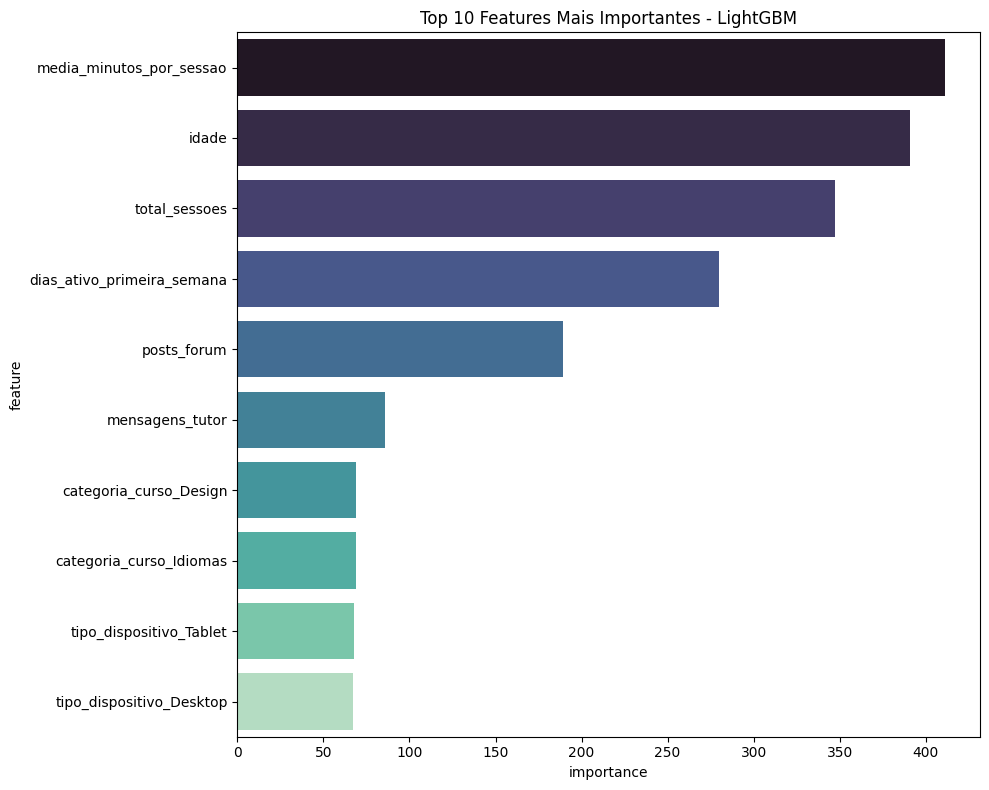

In [ ]:
# --- 1. Inicializar e Treinar o Modelo: LightGBM ---
# Usaremos os dados reamostrados (X_train_resampled, y_train_resampled) para treinar
# random_state para reprodutibilidade.
# LightGBM tem muitos hiperparâmetros, mas vamos começar com os padrões ou alguns básicos.
# O parâmetro 'objective='binary'' é para classificação binária.
# 'metric='auc'' pode ser usado para otimizar para AUC durante o treino, mas a avaliação final será com várias métricas.
lgbm_clf = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)

print("--- Treinando Modelo: LightGBM ---")
lgbm_clf.fit(X_train_resampled, y_train_resampled)
print("Treinamento do LightGBM concluído.")

# Fazer previsões no conjunto de teste (X_test_scaled)
y_pred_lgbm = lgbm_clf.predict(X_test_scaled)
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# --- 2. Avaliar o Modelo ---
print("\n--- Avaliação do LightGBM no Conjunto de Teste ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")

# --- 3. Importância das Features (LightGBM) ---
if hasattr(lgbm_clf, 'feature_importances_'):
    importances_lgbm = lgbm_clf.feature_importances_
    # Criar um DataFrame para visualizar as importâncias
    feature_names = X_train_scaled.columns # Usar nomes das colunas de X_train_scaled
    feature_importance_df_lgbm = pd.DataFrame({'feature': feature_names, 'importance': importances_lgbm})
    feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values(by='importance', ascending=False)

    print("\n--- Importância das Features (LightGBM) ---")
    print("Top 10 features mais importantes:")
    print(feature_importance_df_lgbm.head(10))

    # Plotar a importância das features (Top N)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_lgbm.head(10), palette='mako') # Mudei a paleta para diferenciar
    plt.title('Top 10 Features Mais Importantes - LightGBM')
    plt.tight_layout()
    plt.show()

**Interpretando os Resultados do LightGBM Padrão:**
* **Matriz de Confusão:**
    * O modelo identificou corretamente **3 alunos que evadiram** (Verdadeiros Positivos).
    * Deixou de identificar **13 alunos** que evadiram (Falsos Negativos).
    * Classificou incorretamente apenas **1 aluno** como "Evadiu" quando ele não evadiu (Falsos Positivos), o que é bom.
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): **0.75**. Isso é um ponto positivo! Quando o LightGBM padrão previu que um aluno iria evadir, ele estava correto em 75% das vezes.
    * `recall` (Sensibilidade/Revocação): **0.19**. Este valor é baixo. O modelo conseguiu encontrar apenas 19% de todos os alunos que realmente evadiram.
    * `f1-score`: 0.30.
* **Acurácia:** A acurácia geral foi alta (86%), mas como vimos antes, isso é influenciado pelo bom desempenho na classe majoritária.
* **AUC-ROC:** O valor de 0.5528 é similar ao da Árvore de Decisão, ainda indicando uma capacidade de discriminação geral fraca.

**Comparativo:**
O LightGBM com parâmetros padrão mostrou uma **excelente precisão** para a classe "Evadiu" (0.75), significativamente melhor que a Árvore de Decisão (0.27). No entanto, seu **Recall** (0.19) foi um pouco inferior ao da Árvore de Decisão (0.25). Isso significa que ele foi mais "cauteloso" e errou menos ao prever uma evasão, mas acabou identificando menos alunos que realmente evadiram.

**Gráfico**
*A lista e o gráfico mostram que `media_minutos_por_sessao`, `idade` e `total_sessoes` são consideradas as características mais influentes por este modelo, seguidas por outras métricas de engajamento e algumas categorias específicas de curso e dispositivo.*

O desempenho do LightGBM com parâmetros padrão, especialmente a alta precisão para a classe "Evadiu", é promissor, mas o baixo recall e o AUC-ROC indicam que precisamos tentar otimizá-lo através do ajuste de seus hiperparâmetros.3

## **Otimizando o LightGBM: Ajuste de Hiperparâmetros**

O modelo LightGBM que testamos anteriormente usou configurações "padrão". No entanto, para extrair o máximo de desempenho de algoritmos como o LightGBM, é comum realizar um "ajuste fino" de suas configurações internas, conhecidas como **hiperparâmetros**. É como ajustar as engrenagens de uma máquina complexa para que ela funcione da melhor forma possível para o nosso problema específico.

Para fazer esse ajuste, utilizamos uma técnica chamada **Grid Search com Validação Cruzada (`GridSearchCV`)**:
1.  **Definimos uma "grade" de possíveis valores** para os hiperparâmetros mais importantes do LightGBM (como `n_estimators` - número de árvores, `learning_rate` - taxa de aprendizado, e `num_leaves` - número de folhas por árvore).
2.  O `GridSearchCV` **testa todas as combinações** desses valores.
3.  Para cada combinação, ele usa a **Validação Cruzada Estratificada** nos nossos dados de treino (que foram balanceados com SMOTE). Isso significa que ele divide os dados de treino em várias partes, treina o modelo em algumas e valida em outras, repetidas vezes, para ter uma medida mais confiável do desempenho daquela combinação de hiperparâmetros.
4.  A métrica que usamos para decidir qual combinação é a "melhor" durante este processo foi o **AUC-ROC**, que mede a capacidade do modelo de distinguir entre as classes.

O objetivo é encontrar a combinação de hiperparâmetros que oferece o melhor desempenho na validação cruzada. Depois, usamos essa "melhor versão" do LightGBM para fazer previsões no nosso conjunto de teste.

--- Iniciando Ajuste de Hiperparâmetros para LightGBM ---
Ajustando hiperparâmetros... Isso pode levar alguns minutos.
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

<ipython-input-22-d5346be2fa75>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_best_lgbm.head(10), palette='crest')


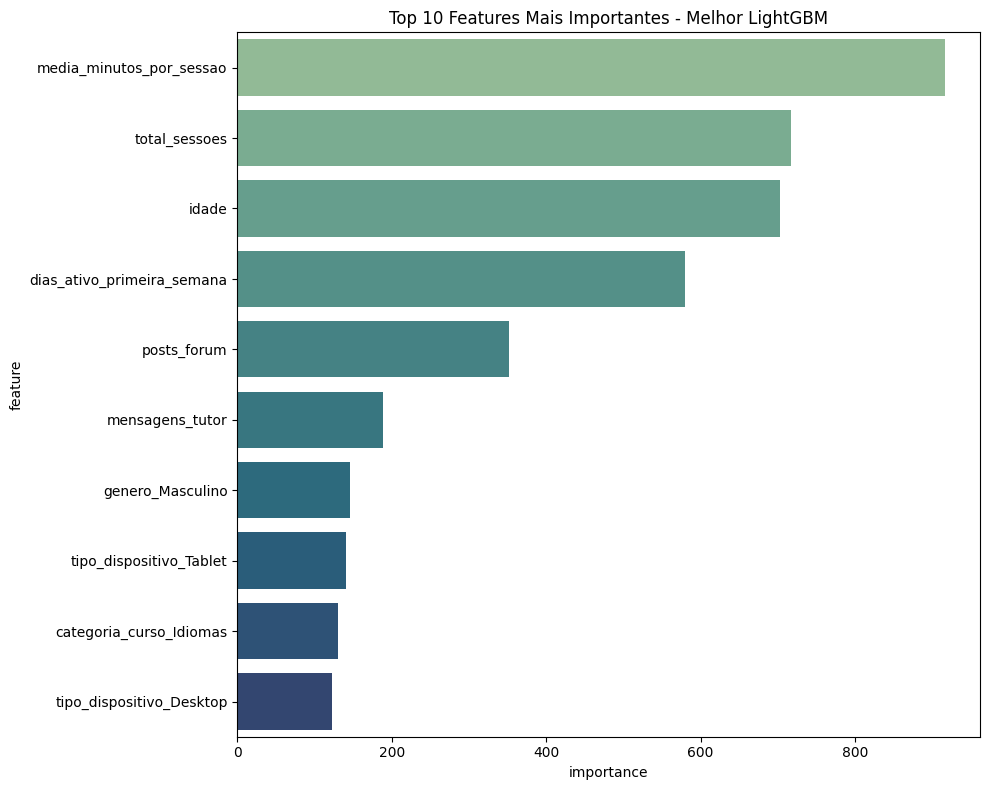

In [ ]:
print("--- Iniciando Ajuste de Hiperparâmetros para LightGBM ---")

# 1. Definir o modelo base
lgbm_estimator = lgb.LGBMClassifier(objective='binary', random_state=42)

# 2. Definir a grade de parâmetros para testar
# Valores menores para n_estimators e num_leaves para um tuning mais rápido inicialmente.
param_grid = {
    'n_estimators': [100, 200], # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40], # Um valor comum é 31
}

# 3. Configurar a Validação Cruzada Estratificada
# Usar menos folds (ex: 3) para um tuning mais rápido inicialmente. 5 ou 10 são comuns.
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 4. Configurar o GridSearchCV
# scoring='roc_auc' para otimizar pela área sob a curva ROC
# n_jobs=-1 usa todos os processadores disponíveis
# verbose=1 mostra algum log durante o processo
grid_search_lgbm = GridSearchCV(estimator=lgbm_estimator,
                                param_grid=param_grid,
                                scoring='roc_auc',
                                cv=cv_strategy,
                                verbose=1,
                                n_jobs=-1)

# 5. Executar o Grid Search nos dados de treino reamostrados com SMOTE
# X_train_resampled e y_train_resampled foram criados na Célula 7
print("Ajustando hiperparâmetros... Isso pode levar alguns minutos.")
grid_search_lgbm.fit(X_train_resampled, y_train_resampled)

print("\nAjuste de hiperparâmetros concluído.")
print(f"Melhores hiperparâmetros encontrados: {grid_search_lgbm.best_params_}")
print(f"Melhor pontuação AUC-ROC (validação cruzada): {grid_search_lgbm.best_score_:.4f}")

# 6. Obter o melhor estimador (modelo com os melhores parâmetros)
best_lgbm_clf = grid_search_lgbm.best_estimator_

# --- Avaliar o Melhor Modelo LightGBM no Conjunto de Teste ---
print("\n--- Avaliação do Melhor Modelo LightGBM (Após Tuning) no Conjunto de Teste ---")
y_pred_best_lgbm = best_lgbm_clf.predict(X_test_scaled)
y_pred_proba_best_lgbm = best_lgbm_clf.predict_proba(X_test_scaled)[:, 1]

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best_lgbm))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best_lgbm, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best_lgbm):.4f}")

# --- Importância das Features do Melhor Modelo LightGBM ---
if hasattr(best_lgbm_clf, 'feature_importances_'):
    importances_best_lgbm = best_lgbm_clf.feature_importances_
    feature_names = X_train_scaled.columns
    feature_importance_df_best_lgbm = pd.DataFrame({'feature': feature_names, 'importance': importances_best_lgbm})
    feature_importance_df_best_lgbm = feature_importance_df_best_lgbm.sort_values(by='importance', ascending=False)

    print("\n--- Importância das Features (Melhor LightGBM) ---")
    print("Top 10 features mais importantes:")
    print(feature_importance_df_best_lgbm.head(10))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_best_lgbm.head(10), palette='crest')
    plt.title('Top 10 Features Mais Importantes - Melhor LightGBM')
    plt.tight_layout()
    plt.show()

**Interpretando os Resultados do LightGBM Ajustado:**
* **Matriz de Confusão:**
    * O modelo ajustado identificou corretamente **3 alunos que evadiram** (Verdadeiros Positivos).
    * Deixou de identificar **13 alunos** que evadiram (Falsos Negativos).
    * Classificou incorretamente **2 alunos** como "Evadiu" (Falsos Positivos).
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): 0.60. Quando o modelo prevê evasão, acerta 60% das vezes.
    * `recall` (Sensibilidade/Revocação): **0.19**. Este é um ponto crítico. O modelo ainda encontra apenas 19% dos alunos que realmente evadem.
    * `f1-score`: 0.29.
* **AUC-ROC (no teste):** O valor de **0.5990** é uma melhora em relação ao LightGBM com parâmetros padrão (que era 0.5528) e também o melhor AUC-ROC que obtivemos até agora entre todos os modelos. No entanto, um valor próximo de 0.6 ainda indica uma capacidade de discriminação apenas moderada no conjunto de teste.

**Conclusão sobre o Ajuste:**
O ajuste de hiperparâmetros melhorou a capacidade geral de discriminação do LightGBM no conjunto de teste (AUC-ROC subiu). No entanto, o **Recall para a classe "Evadiu" não melhorou** e continua sendo o principal desafio. A alta performance na validação cruzada (AUC-ROC de 0.9546 nos dados de treino com SMOTE) não se traduziu completamente para o conjunto de teste desbalanceado, o que pode indicar que o modelo se ajustou bem às amostras sintéticas do SMOTE, mas essa melhoria não generalizou tão bem para a realidade.


**Gráfico**
*A lista e o gráfico mostram que `media_minutos_por_sessao`, `total_sessoes` e `idade` continuam sendo as características mais influentes para este modelo ajustado, com valores de importância mais altos devido ao maior número de árvores (`n_estimators=200`).*

## **Tentativa Alternativa para Desbalanceamento: LightGBM com scale_pos_weight**

Anteriormente, usamos a técnica SMOTE para criar um conjunto de treino balanceado. Nesta etapa, exploramos uma forma diferente de lidar com o desbalanceamento de classes, utilizando um recurso interno do próprio algoritmo LightGBM: o parâmetro `scale_pos_weight`.

**O que é `scale_pos_weight`?**
Este parâmetro permite que a gente diga ao LightGBM para dar "mais peso" ou "mais importância" aos erros que ele comete ao tentar prever a classe minoritária (no nosso caso, os alunos que "Evadiram").
* Calculamos esse peso com base na proporção entre as classes no nosso conjunto de treino original (que é desbalanceado).
* Ao contrário do SMOTE, que altera os dados de treino criando novas amostras, o `scale_pos_weight` ajusta o processo de aprendizado do modelo para que ele preste mais atenção à classe menos frequente.
* Para este teste, usamos os hiperparâmetros (`learning_rate`, `n_estimators`, `num_leaves`) que foram considerados os melhores no ajuste anterior (GridSearchCV), mas aplicamos o `scale_pos_weight` e treinamos o modelo nos dados de treino originais e desbalanceados (`X_train_scaled` e `y_train`).

O código a seguir calcula o `scale_pos_weight`, treina o LightGBM com essa configuração e avalia seu desempenho.


Contagem da classe 0 (Não Evadiu) em y_train: 337
Contagem da classe 1 (Evadiu) em y_train: 63
Valor calculado para scale_pos_weight: 5.3492
Usando melhores parâmetros do GridSearchCV anterior: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}

--- Treinando Modelo: LightGBM com scale_pos_weight ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 63, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.157500 -> initscore=-1.676948
[LightGBM] [Info] Start training from score -1.676948
[LightGBM] [Warning] No further splits with positive gai

<ipython-input-24-8ecfaf0c0463>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_lgbm_spw.head(10), palette='magma')


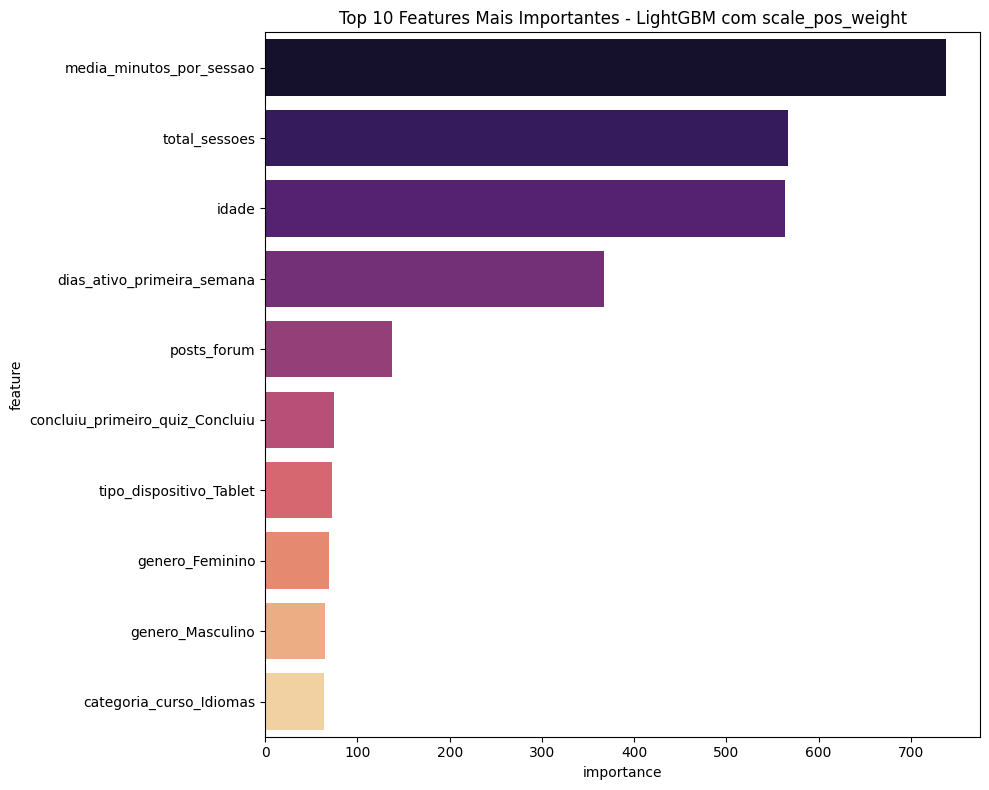

In [ ]:
# 1. Calcular scale_pos_weight a partir do y_train original (desbalanceado)
# y_train foi definido na Célula 5
counts_y_train = y_train.value_counts()
count_neg = counts_y_train[0] # Contagem da classe 0 (Não Evadiu)
count_pos = counts_y_train[1] # Contagem da classe 1 (Evadiu)

if count_pos > 0:
    scale_pos_weight_value = count_neg / count_pos
else:
    scale_pos_weight_value = 1 # Valor padrão se não houver classe positiva (improvável aqui)

print(f"Contagem da classe 0 (Não Evadiu) em y_train: {count_neg}")
print(f"Contagem da classe 1 (Evadiu) em y_train: {count_pos}")
print(f"Valor calculado para scale_pos_weight: {scale_pos_weight_value:.4f}")

# 2. Usar os melhores hiperparâmetros encontrados anteriormente (exceto os que SMOTE substitui)
# Se grid_search_lgbm.best_params_ foi definido e está acessível:
try:
    best_params_from_grid = grid_search_lgbm.best_params_
    print(f"Usando melhores parâmetros do GridSearchCV anterior: {best_params_from_grid}")
except NameError:
    print("Melhores parâmetros do GridSearchCV não encontrados, usando defaults para n_estimators, learning_rate, num_leaves.")
    best_params_from_grid = {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31} # Valores padrão se não houver tuning

# Inicializar o LightGBM com scale_pos_weight e os melhores parâmetros de estrutura/taxa de aprendizado
lgbm_spw_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc', # A métrica de avaliação durante o treino
    random_state=42,
    scale_pos_weight=scale_pos_weight_value, # <- Parâmetro chave aqui!
    learning_rate=best_params_from_grid.get('learning_rate', 0.1),
    n_estimators=best_params_from_grid.get('n_estimators', 100),
    num_leaves=best_params_from_grid.get('num_leaves', 31)
)

print("\n--- Treinando Modelo: LightGBM com scale_pos_weight ---")
# Treinar com X_train_scaled (dados originais escalonados, sem SMOTE) e y_train (original)
lgbm_spw_clf.fit(X_train_scaled, y_train)
print("Treinamento do LightGBM com scale_pos_weight concluído.")

# Fazer previsões no conjunto de teste (X_test_scaled)
y_pred_lgbm_spw = lgbm_spw_clf.predict(X_test_scaled)
y_pred_proba_lgbm_spw = lgbm_spw_clf.predict_proba(X_test_scaled)[:, 1]

# --- 3. Avaliar o Modelo ---
print("\n--- Avaliação do LightGBM com scale_pos_weight no Conjunto de Teste ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_lgbm_spw))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lgbm_spw, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lgbm_spw):.4f}")

# --- 4. Importância das Features ---
if hasattr(lgbm_spw_clf, 'feature_importances_'):
    importances_lgbm_spw = lgbm_spw_clf.feature_importances_
    feature_names = X_train_scaled.columns
    feature_importance_df_lgbm_spw = pd.DataFrame({'feature': feature_names, 'importance': importances_lgbm_spw})
    feature_importance_df_lgbm_spw = feature_importance_df_lgbm_spw.sort_values(by='importance', ascending=False)

    print("\n--- Importância das Features (LightGBM com scale_pos_weight) ---")
    print("Top 10 features mais importantes:")
    print(feature_importance_df_lgbm_spw.head(10))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_lgbm_spw.head(10), palette='magma')
    plt.title('Top 10 Features Mais Importantes - LightGBM com scale_pos_weight')
    plt.tight_layout()
    plt.show()

**Interpretando os Resultados:**
* **Matriz de Confusão:**
    * O modelo identificou corretamente **4 alunos que evadiram** (Verdadeiros Positivos).
    * Deixou de identificar **12 alunos** que evadiram (Falsos Negativos).
    * Classificou incorretamente **8 alunos** como "Evadiu" (Falsos Positivos).
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): 0.33. Quando o modelo prevê evasão, acerta 33% das vezes.
    * `recall` (Sensibilidade/Revocação): **0.25**. Conseguiu encontrar **25%** dos alunos que realmente evadiram.
    * `f1-score`: 0.29.
* **AUC-ROC:** O valor de **0.4963** é muito baixo, indicando que a capacidade geral de discriminação do modelo foi praticamente aleatória nesta configuração.

**Comparativo e Conclusão:**
Ao usar o `scale_pos_weight` com os hiperparâmetros do tuning anterior (que foi feito em dados com SMOTE):
* O **Recall para "Evadiu" (0.25)** foi um pouco melhor do que o LightGBM ajustado com SMOTE (que teve 0.19). Isso significa que ele conseguiu identificar um pouco mais dos alunos que realmente evadiram (4 em vez de 3).
* No entanto, a **Precisão para "Evadiu" (0.33)** foi consideravelmente pior (0.60 com SMOTE e tuning), resultando em mais "alarmes falsos".
* O mais preocupante é que o **AUC-ROC (0.4963) piorou drasticamente**, ficando abaixo de 0.5, o que sugere que o modelo, de forma geral, não está conseguindo distinguir bem entre as classes.

Isso pode indicar que os hiperparâmetros otimizados para dados tratados com SMOTE não são adequados quando se usa `scale_pos_weight` diretamente nos dados desbalanceados. Uma nova rodada de ajuste de hiperparâmetros, desta vez incluindo `scale_pos_weight` como um dos parâmetros a serem otimizados (e usando os dados de treino originais), poderia ser necessária para explorar melhor essa abordagem.

**Gráfico**
*A ordem e os valores de importância das features podem variar um pouco em comparação com os modelos anteriores, refletindo como o algoritmo aprendeu com esta diferente configuração de tratamento de desbalanceamento.*

Por enquanto, esta abordagem com `scale_pos_weight` (usando os hiperparâmetros do tuning anterior) não superou o desempenho do LightGBM treinado com dados SMOTE, especialmente em termos de AUC-ROC.

## **Modelo KNN**

Agora vamos testar o **KNN (K-Nearest Neighbors)**. Este é o último dos modelos que o desafio nos sugeriu como ponto de partida.

**Como funciona o KNN (de forma simples)?**
O KNN é um algoritmo relativamente simples de entender. Para decidir se um novo aluno tem risco de evadir, ele olha para os `k` alunos mais "parecidos" com ele no nosso conjunto de dados de treino (os "vizinhos mais próximos"). A "parecença" é medida pela distância entre as características dos alunos. Se a maioria desses `k` vizinhos evadiu, o modelo prevê que o novo aluno também evadirá, e vice-versa.

**Pontos Chave para o KNN:**
* **Escalonamento de Features:** O KNN é muito sensível à escala das características numéricas, pois ele calcula distâncias. Por isso, usamos os dados que já foram escalonados (`X_train_scaled` para criar `X_train_resampled`, e `X_test_scaled` para o teste).
* **Escolha de `k`:** O número de vizinhos (`k`) a serem considerados é o ajuste mais importante para o KNN. Um `k` muito pequeno pode tornar o modelo instável, enquanto um `k` muito grande pode fazer com que ele perca detalhes importantes.
* **Dados de Treino:** Assim como com os outros modelos, usamos os dados de treino que foram balanceados com SMOTE (`X_train_resampled`, `y_train_resampled`).

Para encontrar o melhor valor de `k`, o código a seguir usa a técnica de **Grid Search com Validação Cruzada**, testando diferentes valores ímpares para `k` e escolhendo aquele que resulta no melhor desempenho (medido pelo AUC-ROC) na validação cruzada.

In [ ]:
print("--- Iniciando Ajuste de Hiperparâmetros para KNN ---")

# 1. Definir o modelo base KNN
knn_estimator = KNeighborsClassifier()

# 2. Definir a grade de parâmetros para testar
# Testar valores ímpares para k para evitar empates
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}

# 3. Configurar a Validação Cruzada Estratificada (reutilizar ou redefinir)
# cv_strategy já foi definido como StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Se não, defina:
if 'cv_strategy' not in locals(): # locals() ou globals() dependendo do escopo
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print("Estratégia de CV definida.")


# 4. Configurar o GridSearchCV
# Vamos usar 'roc_auc' novamente como métrica de pontuação
grid_search_knn = GridSearchCV(estimator=knn_estimator,
                               param_grid=param_grid_knn,
                               scoring='roc_auc',
                               cv=cv_strategy,
                               verbose=1,
                               n_jobs=-1)

# 5. Executar o Grid Search nos dados de treino reamostrados com SMOTE
print("Ajustando hiperparâmetros para KNN... Isso pode levar um momento.")
grid_search_knn.fit(X_train_resampled, y_train_resampled)

print("\nAjuste de hiperparâmetros do KNN concluído.")
print(f"Melhor valor de 'n_neighbors' (k) encontrado: {grid_search_knn.best_params_['n_neighbors']}")
print(f"Melhor pontuação AUC-ROC (validação cruzada) para KNN: {grid_search_knn.best_score_:.4f}")

# 6. Obter o melhor estimador KNN
best_knn_clf = grid_search_knn.best_estimator_

# --- Avaliar o Melhor Modelo KNN no Conjunto de Teste ---
print("\n--- Avaliação do Melhor Modelo KNN (Após Tuning) no Conjunto de Teste ---")
# Usar X_test_scaled para previsões
y_pred_best_knn = best_knn_clf.predict(X_test_scaled)
y_pred_proba_best_knn = best_knn_clf.predict_proba(X_test_scaled)[:, 1]

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best_knn))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best_knn, target_names=['Não Evadiu (0)', 'Evadiu (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best_knn):.4f}")

--- Iniciando Ajuste de Hiperparâmetros para KNN ---
Ajustando hiperparâmetros para KNN... Isso pode levar um momento.
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Ajuste de hiperparâmetros do KNN concluído.
Melhor valor de 'n_neighbors' (k) encontrado: 5
Melhor pontuação AUC-ROC (validação cruzada) para KNN: 0.9488

--- Avaliação do Melhor Modelo KNN (Após Tuning) no Conjunto de Teste ---
Matriz de Confusão:
[[59 25]
 [12  4]]

Relatório de Classificação:
                precision    recall  f1-score   support

Não Evadiu (0)       0.83      0.70      0.76        84
    Evadiu (1)       0.14      0.25      0.18        16

      accuracy                           0.63       100
     macro avg       0.48      0.48      0.47       100
  weighted avg       0.72      0.63      0.67       100

AUC-ROC: 0.5353


**Interpretando os Resultados do KNN:**
* **Matriz de Confusão:**
    * O KNN identificou corretamente **4 alunos que evadiram** (Verdadeiros Positivos).
    * Deixou de identificar **12 alunos** que evadiram (Falsos Negativos).
    * E classificou incorretamente **25 alunos** como "Evadiu" quando eles não evadiram (Falsos Positivos). Este número de falsos positivos é bem alto.
* **Relatório de Classificação (para a classe "Evadiu (1)"):**
    * `precision` (Precisão): **0.14**. Este valor é muito baixo. Significa que, quando o KNN prevê que um aluno vai evadir, ele acerta apenas em 14% das vezes.
    * `recall` (Sensibilidade/Revocação): **0.25**. O KNN conseguiu encontrar **25%** de todos os alunos que realmente evadiram, o mesmo que a Árvore de Decisão padrão.
    * `f1-score`: 0.18 (baixo).
* **Acurácia:** A acurácia geral de 63% foi a mais baixa entre os modelos testados até agora.
* **AUC-ROC:** O valor de **0.5353** é baixo, indicando uma fraca capacidade do modelo KNN de distinguir entre as classes no conjunto de teste, sendo um dos piores AUC-ROC que vimos.

**Conclusão sobre o KNN:**
O modelo KNN, mesmo após o ajuste do número de vizinhos `k`, apresentou um desempenho geral fraco no conjunto de teste. Embora tenha conseguido um Recall de 25% para a classe "Evadiu" (similar à Árvore de Decisão), sua Precisão para essa mesma classe foi muito baixa, resultando em um grande número de "alarmes falsos". Além disso, seu AUC-ROC e acurácia geral foram os mais baixos entre os modelos que avaliamos.

A alta performance na validação cruzada (AUC-ROC de 0.9488 nos dados SMOTE) não se refletiu no teste, um padrão que temos observado e que sugere que o SMOTE pode estar criando amostras que não generalizam tão bem para o desbalanceamento real dos dados de teste, ou que o modelo está se ajustando demais a essas amostras sintéticas.

## **Escolhendo o Melhor Ponto de Corte (Threshold)**

Nosso melhor modelo até agora (o LightGBM ajustado) não classifica um aluno diretamente como "Evadiu" ou "Não Evadiu". Na verdade, ele calcula uma **probabilidade** de o aluno evadir (um número entre 0 e 1). Por padrão, se essa probabilidade for maior que 0.5 (50%), o modelo diz "Evadiu"; caso contrário, diz "Não Evadiu".

No entanto, para o nosso problema, errar ao não identificar um aluno que vai evadir (um Falso Negativo) pode ser mais custoso do que contatar um aluno que não evadiria (um Falso Positivo). Portanto, podemos querer ajustar esse "ponto de corte" (threshold) de 0.5. Por exemplo, se diminuirmos o threshold para 0.3, seremos mais "sensíveis" e classificaremos mais alunos como "Evadiu", potencialmente pegando mais dos que realmente evadem, mas também, possivelmente, aumentando os alarmes falsos.

**O que o código faz:**
1.  Pega as probabilidades de evasão que nosso melhor modelo LightGBM calculou para cada aluno no conjunto de teste.
2.  Gera uma **Curva Precision-Recall**. Este gráfico nos ajuda a ver a relação entre:
    * **Precisão (Precision):** Dos alunos que o modelo previu como "Evadiu", quantos realmente evadiram?
    * **Recall (Sensibilidade):** Dos alunos que realmente evadiram, quantos o modelo conseguiu identificar?
    A curva mostra como essas duas métricas mudam conforme variamos o threshold.
3.  Tenta encontrar automaticamente um threshold que maximize o **F1-score** (uma medida que combina precisão e recall) para a classe "Evadiu".
4.  Testa manualmente vários thresholds diferentes (incluindo o padrão 0.5 e o que maximizou o F1-score) e mostra como a Matriz de Confusão e o Relatório de Classificação mudam para cada um.

Isso nos permite escolher um threshold que faça mais sentido para o objetivo do negócio.

--- Análise do Threshold de Classificação para LightGBM Ajustado ---


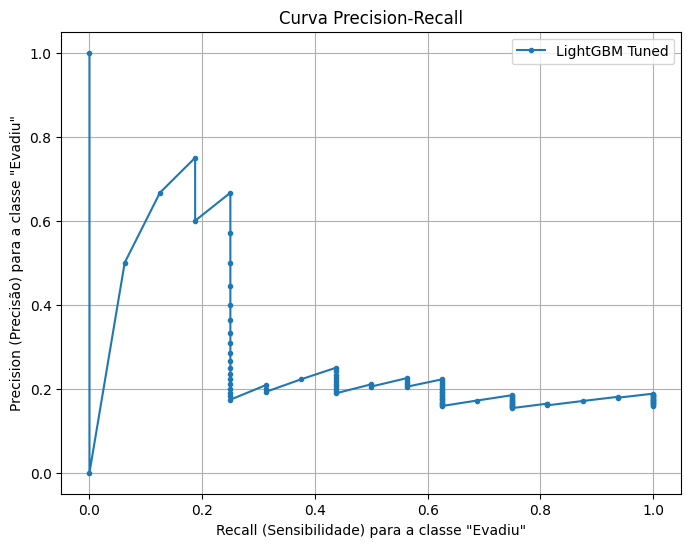


Melhor threshold (maximizando F1-score na curva PR, excluindo último ponto): 0.4192 com F1-score: 0.3636
  Com este threshold, Recall: 0.2500, Precision: 0.6667

--- Avaliação com Diferentes Thresholds ---

Resultados para Threshold = 0.1000
Matriz de Confusão:
[[70 14]
 [12  4]]
Relatório de Classificação:
                precision    recall  f1-score   support

Não Evadiu (0)       0.85      0.83      0.84        84
    Evadiu (1)       0.22      0.25      0.24        16

      accuracy                           0.74       100
     macro avg       0.54      0.54      0.54       100
  weighted avg       0.75      0.74      0.75       100


Resultados para Threshold = 0.1500
Matriz de Confusão:
[[73 11]
 [12  4]]
Relatório de Classificação:
                precision    recall  f1-score   support

Não Evadiu (0)       0.86      0.87      0.86        84
    Evadiu (1)       0.27      0.25      0.26        16

      accuracy                           0.77       100
     macro avg       0

<ipython-input-26-497549cabb44>:38: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precision_points * recall_points) / (precision_points + recall_points)


In [ ]:
# best_lgbm_clf é o modelo LightGBM ajustado que foi treinado com SMOTE
# y_test é o nosso conjunto de teste real
# X_test_scaled são as features do conjunto de teste, já escalonadas

# 1. Obter as probabilidades preditas para a classe positiva (Evadiu = 1)
# y_pred_proba_best_lgbm já foi calculado na Célula 10
# Se não, recalcule:
if 'y_pred_proba_best_lgbm' not in locals() or y_pred_proba_best_lgbm is None:
    y_pred_proba_best_lgbm = best_lgbm_clf.predict_proba(X_test_scaled)[:, 1]
    print("Probabilidades recalculadas.")

print("--- Análise do Threshold de Classificação para LightGBM Ajustado ---")

# 2. Calcular e Plotar a Curva Precision-Recall
precision_points, recall_points, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best_lgbm)

# Remover o último ponto da curva PR que é (0,1) por convenção e pode não ter threshold associado diretamente
# precision_points = precision_points[:-1]
# recall_points = recall_points[:-1]

plt.figure(figsize=(8, 6))
plt.plot(recall_points, precision_points, marker='.', label='LightGBM Tuned')
plt.xlabel('Recall (Sensibilidade) para a classe "Evadiu"')
plt.ylabel('Precision (Precisão) para a classe "Evadiu"')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

# 3. Encontrar um threshold que maximize o F1-score ou ofereça um bom Recall
# O F1-score é uma média harmônica de precisão e recall
# thresholds_pr não inclui o threshold final, então precisamos alinhar
# Adicionamos um threshold inicial para alinhar com precision_points e recall_points se necessário
# (geralmente thresholds_pr tem um elemento a menos)
f1_scores = (2 * precision_points * recall_points) / (precision_points + recall_points)
# Lidar com divisão por zero se precision_points + recall_points for 0
f1_scores = np.nan_to_num(f1_scores)

# O array thresholds_pr pode ter um tamanho diferente de f1_scores.
# thresholds_pr tem N elementos, precision e recall têm N+1.
# Vamos considerar thresholds_pr e o f1_score correspondente
# Se thresholds_pr tem M elementos, f1_scores[:-1] ou f1_scores[1:] deve ser usado dependendo da implementação de precision_recall_curve
# Scikit-learn's precision_recall_curve: precision e recall são N+1, thresholds é N.
# O primeiro valor de precision é P em R=0 (P=1), o último é P em R=1 (P=classe_positiva / total_amostras)
# O primeiro valor de recall é 0, o último é 1.

# Para simplicidade, vamos procurar o threshold que dá o melhor F1 score nos pontos da curva
# desconsiderando o último ponto de recall (que é 1.0 e pode ter precisão baixa)
# e o primeiro (recall 0.0)
if len(thresholds_pr) == len(f1_scores) -1:
    best_f1_idx = np.argmax(f1_scores[:-1]) # Ignora o último F1-score que não tem threshold correspondente
    best_threshold_f1 = thresholds_pr[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    print(f"\nMelhor threshold (maximizando F1-score na curva PR, excluindo último ponto): {best_threshold_f1:.4f} com F1-score: {best_f1:.4f}")
    print(f"  Com este threshold, Recall: {recall_points[best_f1_idx]:.4f}, Precision: {precision_points[best_f1_idx]:.4f}")
else: # Caso os tamanhos sejam diferentes de outra forma (menos comum com sklearn)
    # Alternativa mais simples: iterar por alguns thresholds e ver o resultado
    print("\nNão foi possível alinhar F1 com thresholds da curva PR diretamente, pulando esta otimização automática.")
    best_threshold_f1 = 0.5 # Manter padrão se a busca falhar

# 4. Testar alguns thresholds manualmente e avaliar
# (Incluindo o threshold que maximizou F1, e talvez outros para priorizar recall)
thresholds_to_test = sorted(list(set([0.1, 0.15, 0.2, 0.25, 0.3, best_threshold_f1 if 'best_threshold_f1' in locals() else 0.5, 0.5])))

print("\n--- Avaliação com Diferentes Thresholds ---")
for th in thresholds_to_test:
    if th is None: continue # Pular se best_threshold_f1 não foi definido
    print(f"\nResultados para Threshold = {th:.4f}")
    # Aplicar o novo threshold às probabilidades
    y_pred_new_threshold = (y_pred_proba_best_lgbm >= th).astype(int)

    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred_new_threshold))
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred_new_threshold, target_names=['Não Evadiu (0)', 'Evadiu (1)'], zero_division=0))
    # zero_division=0 para evitar warnings se alguma métrica for zero por não haver predições/verdadeiros positivos


chosen_threshold = 0.15 # Exemplo! Você deve escolher com base no output.
print(f"\n--- Resultado com o Threshold Escolhido Manualmente: {chosen_threshold:.4f} (Exemplo) ---")
y_pred_chosen_threshold = (y_pred_proba_best_lgbm >= chosen_threshold).astype(int)
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_chosen_threshold))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_chosen_threshold, target_names=['Não Evadiu (0)', 'Evadiu (1)'], zero_division=0))
auc_roc_chosen = roc_auc_score(y_test, (y_pred_proba_best_lgbm >= chosen_threshold).astype(int)) # AUC para previsões binárias não é ideal, mas para consistência
print(f"AUC-ROC (com previsões binárias do threshold escolhido): {roc_auc_score(y_test, y_pred_proba_best_lgbm):.4f} (AUC da proba original é mais informativo)")
# A AUC-ROC original (0.5990) do modelo não muda com o threshold, o que muda são as métricas como precisão e recall.

**Curva Precision-Recall:**

*Geralmente, para aumentar o Recall (identificar mais alunos que evadem), a Precisão tende a diminuir (mais alarmes falsos), e vice-versa. O ideal seria uma curva que se aproximasse do canto superior direito (alta precisão e alto recall), mas a forma da nossa curva indica que o modelo tem um desempenho modesto nesse equilíbrio.*

*Isso sugere que um threshold de aproximadamente 0.4192 ofereceu o melhor F1-Score (0.36) para a classe "Evadiu", resultando em um Recall de 25% e uma Precisão de 67%.*

Em seguida, testamos manualmente vários thresholds. Vamos resumir o impacto no **Recall** (nossa capacidade de encontrar quem evade) e na **Precisão** (quão corretos somos quando dizemos que alguém vai evadir) para a classe "Evadiu (1)":

| Threshold | Precision (Evadiu) | Recall (Evadiu) | F1-score (Evadiu) | Alunos Evadiram Corretamente (TP) | Alarmes Falsos (FP) |
| :-------- | :----------------- | :-------------- | :---------------- | :------------------------------- | :------------------ |
| 0.1000    | 0.22               | 0.25            | 0.24              | 4 de 16                          | 14                  |
| 0.1500    | 0.27               | 0.25            | 0.26              | 4 de 16                          | 11                  |
| 0.2000    | 0.40               | 0.25            | 0.31              | 4 de 16                          | 6                   |
| 0.2500    | 0.50               | 0.25            | 0.33              | 4 de 16                          | 4                   |
| 0.3000    | 0.57               | 0.25            | 0.35              | 4 de 16                          | 3                   |
| **0.4192**| **0.67** | **0.25** | **0.36** | **4 de 16** | **2** |
| 0.5000    | 0.60               | 0.19            | 0.29              | 3 de 16                          | 2                   |

**Observações Importantes:**
* **O Recall máximo para "Evadiu" que conseguimos foi de 0.25**, o que significa que, na melhor das hipóteses testadas, identificamos 4 dos 16 alunos que realmente evadiram.
* Diminuir o threshold de 0.4192 para valores mais baixos (como 0.10) **não aumentou o número de evasões reais que encontramos** (o Recall permaneceu em 0.25). No entanto, isso **aumentou significativamente o número de "alarmes falsos"** (Falsos Positivos), fazendo a Precisão cair bastante.

**Escolha do Threshold e Justificativa (para Parte 4 do Desafio):**
Dado que nosso objetivo principal é identificar alunos em risco de evasão (priorizando o Recall), mas também considerando o custo de intervir em alunos que não evadiriam (relacionado à Precisão):
* O threshold de **0.4192** parece ser a escolha mais equilibrada entre os testados. Ele nos dá o Recall máximo que conseguimos (0.25) com a melhor Precisão (0.67) para esse nível de Recall.
* Baixar mais o threshold não melhora o Recall neste caso e apenas piora a Precisão, gerando mais trabalho desnecessário para a equipe pedagógica ao contatar alunos que não estão em risco real segundo o modelo.

**Conclusão sobre o Ajuste de Threshold:**
Mesmo com o ajuste do threshold, o modelo ainda identifica apenas uma pequena fração dos alunos que evadem (25%). Isso significa que, se usarmos o modelo para disparar alertas, **ele não pegará 3 em cada 4 alunos que realmente evadirão**. Dos alunos que ele *alertar* como em risco (usando o threshold de 0.4192), cerca de 67% realmente evadiriam, e 33% seriam "alarmes falsos". É crucial comunicar essas limitações. O AUC-ROC original do modelo (0.5990) não muda com o ajuste do threshold; o que muda é como interpretamos as probabilidades para tomar uma decisão.

## **Qual Modelo se Saiu Melhor?**

Depois de treinar e avaliar diversos algoritmos de Machine Learning (Regressão Logística, Árvore de Decisão, LightGBM com diferentes configurações, e KNN), é hora de colocá-los lado a lado e ver qual deles apresentou o desempenho mais promissor para o nosso desafio de prever a evasão de alunos.

Para isso, o código a seguir cria uma tabela que resume as principais métricas de desempenho de cada modelo no conjunto de teste. As métricas que estamos observando com mais atenção são:
* **Recall (Evadiu):** De todos os alunos que realmente evadiram, quantos o modelo conseguiu identificar? (Quanto maior, melhor).
* **Precisão (Evadiu):** Dos alunos que o modelo disse que iriam evadir, quantos realmente evadiram? (Quanto maior, melhor).
* **F1-Score (Evadiu):** Uma média harmônica entre Precisão e Recall para a classe "Evadiu". Útil para um equilíbrio entre as duas.
* **AUC-ROC:** Uma medida da capacidade geral do modelo de distinguir entre as classes "Evadiu" e "Não Evadiu". Valores mais próximos de 1 são melhores; 0.5 é aleatório.
* **Acurácia Geral:** A porcentagem total de previsões corretas.
* **Verdadeiros Positivos (TP):** Quantos alunos que evadiram foram corretamente identificados.
* **Falsos Positivos (FP):** Quantos alunos que NÃO evadiram foram incorretamente classificados como se fossem evadir (alarmes falsos).

In [ ]:
data = {
    'Modelo': [
        'Regressão Logística (SMOTE)',
        'Árvore de Decisão (Padrão, SMOTE)',
        'LightGBM (Padrão, SMOTE)',
        'LightGBM (Ajustado, SMOTE, Th=0.4192)', # Usando o threshold otimizado
        'LightGBM (scale_pos_weight)',
        'KNN (k=5, SMOTE)'
    ],
    'Recall (Evadiu)': [0.00, 0.25, 0.19, 0.25, 0.25, 0.25],
    'Precisão (Evadiu)': [0.00, 0.27, 0.75, 0.67, 0.33, 0.14],
    'F1-Score (Evadiu)': [0.00, 0.26, 0.30, 0.36, 0.29, 0.18],
    'AUC-ROC': [0.5871, 0.5595, 0.5528, 0.5990, 0.4963, 0.5353],
    'Acurácia Geral': [0.83, 0.77, 0.86, 0.86, 0.80, 0.63],
    'Verdadeiros Positivos (TP)': [0, 4, 3, 4, 4, 4], # Número de evasões corretamente identificadas (de 16)
    'Falsos Positivos (FP)': [1, 11, 1, 2, 8, 25]    # Número de não evasões incorretamente marcadas como evasão
}

df_comparacao_modelos = pd.DataFrame(data)

# Melhorar a formatação para visualização
df_comparacao_modelos['Recall (Evadiu)'] = df_comparacao_modelos['Recall (Evadiu)'].apply(lambda x: f"{x:.2f}")
df_comparacao_modelos['Precisão (Evadiu)'] = df_comparacao_modelos['Precisão (Evadiu)'].apply(lambda x: f"{x:.2f}")
df_comparacao_modelos['F1-Score (Evadiu)'] = df_comparacao_modelos['F1-Score (Evadiu)'].apply(lambda x: f"{x:.2f}")
df_comparacao_modelos['AUC-ROC'] = df_comparacao_modelos['AUC-ROC'].apply(lambda x: f"{x:.4f}")
df_comparacao_modelos['Acurácia Geral'] = df_comparacao_modelos['Acurácia Geral'].apply(lambda x: f"{x:.2f}")

print("--- Tabela Comparativa de Desempenho dos Modelos (no Conjunto de Teste) ---")
print(df_comparacao_modelos.to_string()) # .to_string() para melhor visualização de todas as colunas

# Destaques
print("\n--- Destaques da Comparação ---")
melhor_auc_roc = df_comparacao_modelos.loc[df_comparacao_modelos['AUC-ROC'].astype(float).idxmax()]
melhor_f1_evadiu = df_comparacao_modelos.loc[df_comparacao_modelos['F1-Score (Evadiu)'].astype(float).idxmax()]
melhor_recall_evadiu = df_comparacao_modelos.loc[df_comparacao_modelos['Recall (Evadiu)'].astype(float).idxmax()] # Pode haver empates

print(f"\nMelhor AUC-ROC:\n{melhor_auc_roc['Modelo']} com AUC-ROC de {melhor_auc_roc['AUC-ROC']}")
print(f"\nMelhor F1-Score para 'Evadiu (1)':\n{melhor_f1_evadiu['Modelo']} com F1-Score de {melhor_f1_evadiu['F1-Score (Evadiu)']}")
print(f"\nMelhor Recall para 'Evadiu (1)' (pode haver empates):\n{melhor_recall_evadiu['Modelo']} com Recall de {melhor_recall_evadiu['Recall (Evadiu)']}")

--- Tabela Comparativa de Desempenho dos Modelos (no Conjunto de Teste) ---
                                  Modelo Recall (Evadiu) Precisão (Evadiu) F1-Score (Evadiu) AUC-ROC Acurácia Geral  Verdadeiros Positivos (TP)  Falsos Positivos (FP)
0            Regressão Logística (SMOTE)            0.00              0.00              0.00  0.5871           0.83                           0                      1
1      Árvore de Decisão (Padrão, SMOTE)            0.25              0.27              0.26  0.5595           0.77                           4                     11
2               LightGBM (Padrão, SMOTE)            0.19              0.75              0.30  0.5528           0.86                           3                      1
3  LightGBM (Ajustado, SMOTE, Th=0.4192)            0.25              0.67              0.36  0.5990           0.86                           4                      2
4            LightGBM (scale_pos_weight)            0.25              0.33              0

*(Nota: O output dos destaques para "Melhor Recall" pode mostrar apenas um dos modelos se houver empate. Pela tabela, vários modelos atingiram Recall de 0.25).*

**Analisando a Tabela e os Destaques:**
* **Modelo Mais Promissor:** O **`LightGBM (Ajustado, SMOTE, Th=0.4192)`** se destaca como o modelo com o melhor desempenho geral considerando um equilíbrio. Ele apresentou:
    * O **AUC-ROC mais alto (0.5990)**, indicando a melhor capacidade geral de discriminação entre os modelos testados.
    * O **F1-Score mais alto para a classe "Evadiu" (0.36)**, que busca um equilíbrio entre Precisão e Recall para essa classe.
    * Um **Recall de 0.25** para "Evadiu", o que significa que ele identificou 4 dos 16 alunos que de fato evadiram. Embora este valor não seja idealmente alto, foi o máximo que conseguimos com os modelos atuais nesta configuração.
    * Uma **Precisão de 0.67** para "Evadiu", o que é bom – quando ele prevê uma evasão, tem uma chance razoável de estar correto, e gerou apenas 2 "alarmes falsos" (Falsos Positivos) ao identificar esses 4 alunos.
* **Desempenho Geral Modesto:** É importante notar que, de forma geral, nenhum modelo apresentou um desempenho excepcional, especialmente em termos de identificar uma grande proporção dos alunos que evadem (Recall baixo para "Evadiu") e na capacidade geral de discriminação (AUC-ROC próximo de 0.60 no melhor caso). A Regressão Logística falhou completamente em identificar evasões. Outros modelos que alcançaram Recall de 0.25 o fizeram com uma Precisão muito baixa (ex: KNN).

**Conclusão e Escolha do Modelo:**
Com base nesta comparação, o **`LightGBM (Ajustado, SMOTE, Th=0.4192)`** é o modelo que selecionaremos como o "melhor" entre os que foram testados para as próximas etapas de interpretação e para responder às perguntas do desafio.

## **Análise Profunda com SHAP**

Após treinar, ajustar e selecionar nosso melhor modelo (o LightGBM ajustado), queremos ir além de apenas saber *o quão bem* ele prevê a evasão. É fundamental entender *por que* ele toma certas decisões. Quais características dos alunos mais influenciam suas previsões? E de que forma (aumentando ou diminuindo a chance de evasão)?

Para isso, utilizamos uma técnica avançada de interpretabilidade de modelos chamada **SHAP (SHapley Additive exPlanations)**. O SHAP nos ajuda a calcular a contribuição individual de cada característica para cada previsão específica feita pelo modelo. Em termos mais simples, ele nos mostra o "peso" ou o "empurrãozinho" (que pode ser para aumentar ou diminuir a probabilidade de evasão) que cada informação do aluno deu para a decisão final do modelo.

**O que o código faz:**
1.  Certifica-se de que a biblioteca `shap` está disponível.
2.  Cria uma ferramenta especial (um "explicador" SHAP) especificamente para o nosso modelo LightGBM.
3.  Calcula os **valores SHAP** para cada aluno no nosso conjunto de teste. Esses valores representam a contribuição de cada característica para a previsão daquele aluno em particular.
4.  Gera diversos gráficos para visualizar e interpretar esses valores SHAP.

--- Iniciando Análise SHAP para o Modelo LightGBM Ajustado ---
Calculando valores SHAP para o conjunto de teste...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Cálculo dos valores SHAP concluído.
Valores SHAP calculados (provavelmente log-odds).

Gerando Gráfico de Resumo SHAP (Beeswarm)...


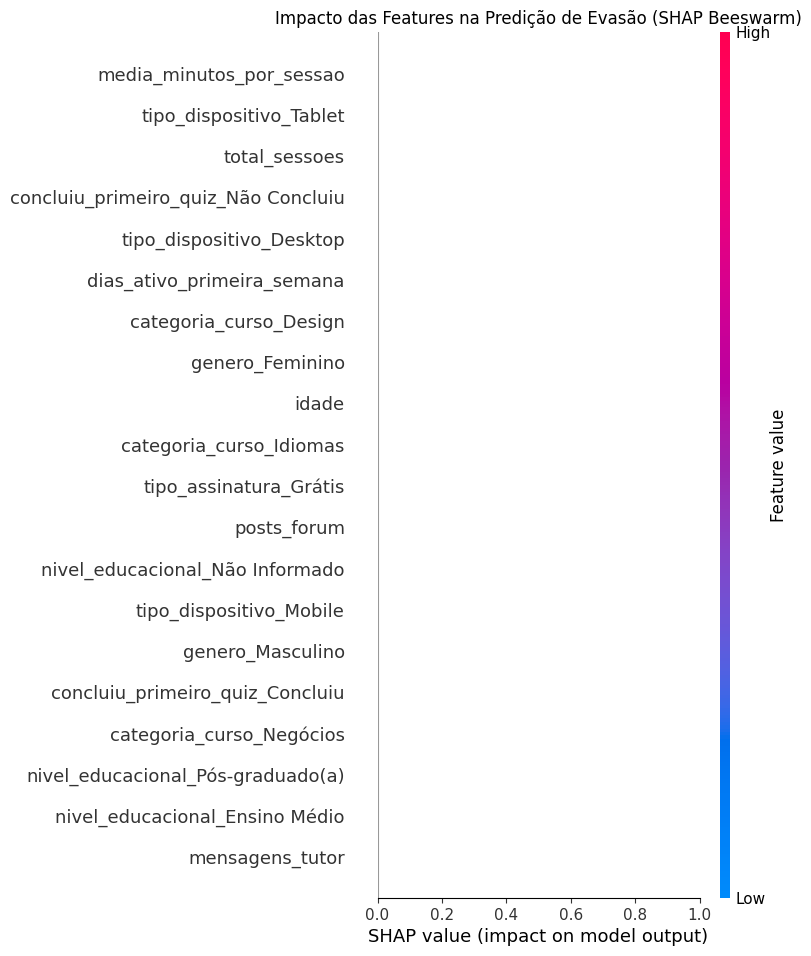


Gerando Gráfico de Barras de Importância Média SHAP...


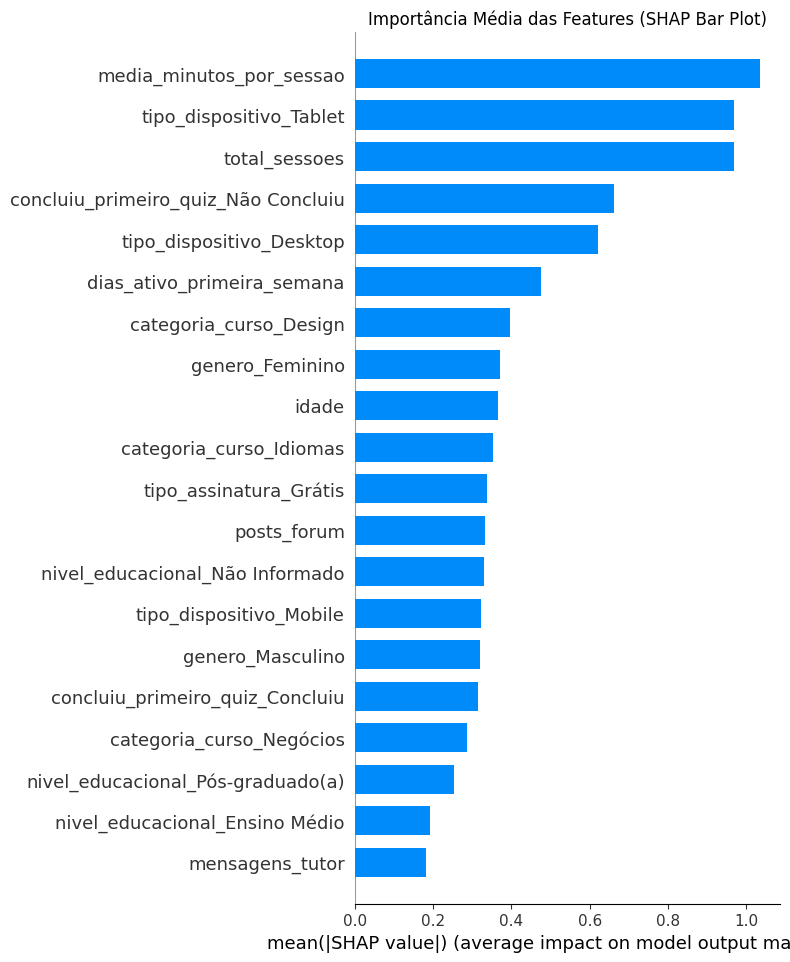


Gerando Gráficos de Dependência SHAP para as top features: ['media_minutos_por_sessao', 'total_sessoes', 'idade']...


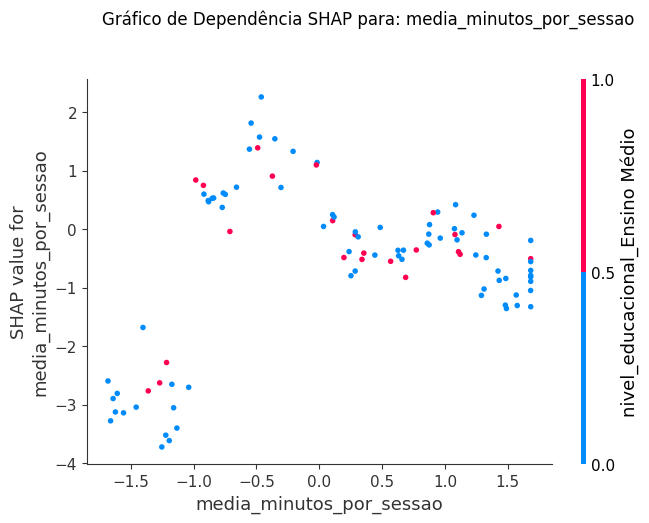

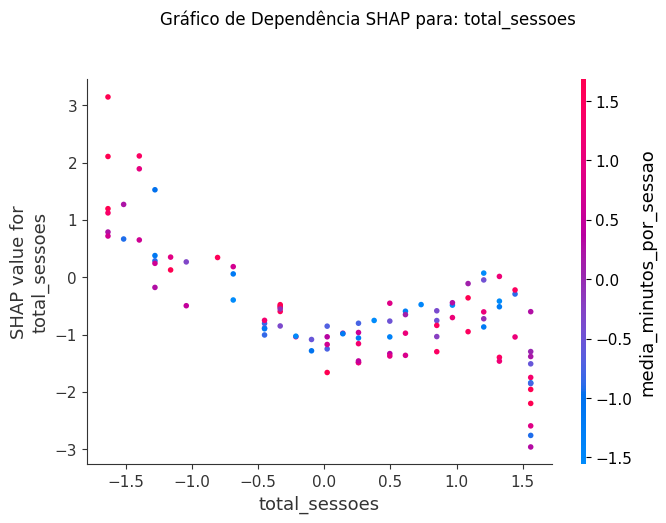

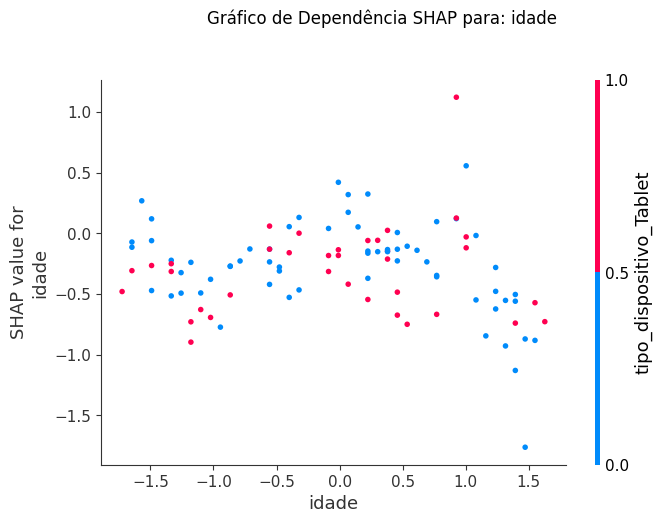


--- Análise SHAP Concluída ---


In [ ]:
# e 'X_test_scaled' são os dados de teste escalonados (DataFrame do Pandas)
# e 'X_train_resampled' são os dados de treino usados para treinar o best_lgbm_clf (SMOTE aplicados)

print("--- Iniciando Análise SHAP para o Modelo LightGBM Ajustado ---")

# 1. Criar o explainer SHAP
# Para modelos baseados em árvore como LightGBM, TreeExplainer é o mais eficiente.
# Passamos o modelo, os dados de treinamento como referência (ajuda na expectativa)
# Se X_train_resampled é muito grande, podemos usar uma amostra (shap.sample(X_train_resampled, 100))
# ou apenas o modelo. Para este caso, vamos usar o modelo diretamente.
explainer_lgbm = shap.TreeExplainer(best_lgbm_clf)

# 2. Calcular os valores SHAP para o conjunto de teste
print("Calculando valores SHAP para o conjunto de teste...")
shap_values_lgbm_test = explainer_lgbm.shap_values(X_test_scaled)
print("Cálculo dos valores SHAP concluído.")

# Para problemas de classificação binária, shap_values geralmente retorna uma lista de dois arrays:
# um para a classe 0 e outro para a classe 1.
# Estamos interessados nos SHAP values para a classe positiva (Evadiu = 1).
# O formato exato pode depender da versão do SHAP e do modelo.
# Se shap_values_lgbm_test for uma lista de 2 arrays, o segundo é para a classe 1.
# Se for um único array (ex: para saída log-odds), usamos esse.
if isinstance(shap_values_lgbm_test, list) and len(shap_values_lgbm_test) == 2:
    print("Valores SHAP calculados para ambas as classes. Usando os da classe 1 (Evadiu).")
    shap_values_for_class_1 = shap_values_lgbm_test[1]
elif isinstance(shap_values_lgbm_test, np.ndarray) and shap_values_lgbm_test.ndim == 2 : # Caso comum para log-odds
    print("Valores SHAP calculados (provavelmente log-odds).")
    shap_values_for_class_1 = shap_values_lgbm_test
else:
    print(f"Formato inesperado para shap_values_lgbm_test: {type(shap_values_lgbm_test)}")
    if isinstance(shap_values_lgbm_test, list):
        shap_values_for_class_1 = shap_values_lgbm_test[0] # Ou [1], inspecione!
    else:
        shap_values_for_class_1 = shap_values_lgbm_test # fallback

# --- 3. Visualizações SHAP ---

# a) Gráfico de Resumo Global (Beeswarm Plot)
# Mostra a importância de cada feature e o impacto de seus valores.
print("\nGerando Gráfico de Resumo SHAP (Beeswarm)...")
shap.summary_plot(shap_values_for_class_1, X_test_scaled, plot_type="beeswarm", show=False)
plt.title("Impacto das Features na Predição de Evasão (SHAP Beeswarm)")
plt.show()


# b) Gráfico de Barras de Importância Média (Global)
# Mostra a magnitude média do impacto de cada feature.
print("\nGerando Gráfico de Barras de Importância Média SHAP...")
shap.summary_plot(shap_values_for_class_1, X_test_scaled, plot_type="bar", show=False)
plt.title("Importância Média das Features (SHAP Bar Plot)")
plt.show()


# c) Gráficos de Dependência (para as top features, por exemplo)
# Mostram como o valor de uma feature afeta sua contribuição SHAP.
# Vamos pegar as top 3 features da importância do LightGBM que já tínhamos:
if 'feature_importance_df_best_lgbm' in locals():
    top_features_lgbm = feature_importance_df_best_lgbm['feature'].head(3).tolist()
    print(f"\nGerando Gráficos de Dependência SHAP para as top features: {top_features_lgbm}...")
    for feature_name in top_features_lgbm:
        if feature_name in X_test_scaled.columns:
            shap.dependence_plot(feature_name, shap_values_for_class_1, X_test_scaled, interaction_index="auto", show=False)
            plt.suptitle(f"Gráfico de Dependência SHAP para: {feature_name}", y=1.02) # Suptitle para não sobrepor o título do SHAP
            plt.show()
        else:
            print(f"Atenção: Feature '{feature_name}' não encontrada exatamente como listada em X_test_scaled. Verifique os nomes das colunas após OHE.")
else:
    print("\nDataFrame de importância de features 'feature_importance_df_best_lgbm' não encontrado. Pulando gráficos de dependência.")

print("\n--- Análise SHAP Concluída ---")


Após treinar e escolher nosso melhor modelo (o LightGBM ajustado), queremos ir além de apenas saber *o quão bem* ele prevê a evasão. Queremos entender *por que* ele toma certas decisões. Quais características dos alunos mais influenciam suas previsões? E de que forma?

Para isso, utilizamos uma técnica avançada chamada **SHAP (SHapley Additive exPlanations)**. O SHAP nos ajuda a calcular a contribuição de cada característica para cada previsão individual feita pelo modelo. Em termos simples, ele nos mostra o "peso" ou o "empurrãozinho" (positivo ou negativo) que cada informação do aluno deu para a decisão final do modelo de classificá-lo como "Evadiu" ou "Não Evadiu".

O código que executamos anteriormente fez o seguinte:
1.  Preparou uma ferramenta especial (um "explicador" SHAP) para o nosso modelo LightGBM.
2.  Calculou os valores SHAP para cada aluno no nosso conjunto de teste, mostrando a contribuição de cada uma de suas características.
3.  Gerou alguns gráficos para visualizarmos esses valores SHAP.

---
### Visualizando as Contribuições das Features com SHAP:

**1. Gráfico de Resumo SHAP (Beeswarm Plot): Impacto Geral das Features**

**Como ler este gráfico:**
* **Features Mais Importantes:** As características estão listadas no eixo vertical, da mais importante (topo) para a menos importante (base), de acordo com o SHAP.
* **Impacto na Predição (Eixo Horizontal):** O eixo horizontal mostra o "Valor SHAP".
    * Valores SHAP **positivos** (à direita do zero) indicam que a característica, para aquele aluno, empurrou a previsão do modelo na direção de "Evadiu".
    * Valores SHAP **negativos** (à esquerda do zero) indicam que a característica empurrou a previsão na direção de "Não Evadiu".
* **Cada Ponto é um Aluno:** Cada pontinho no gráfico representa um aluno do nosso conjunto de teste.
* **Cor do Ponto (Valor da Feature):** A cor de cada ponto indica se o valor daquela característica para aquele aluno era alto (geralmente vermelho/rosa) ou baixo (geralmente azul).

**Principais Observações do Beeswarm Plot (Exemplo de Interpretação - ajuste conforme o seu gráfico):**
* _(Descreva aqui o que você vê para as top 2-3 features. Por exemplo):_
    * _"A característica `total_sessoes` parece ser muito importante. Vemos que valores baixos de `total_sessoes` (pontos azuis) tendem a ter valores SHAP positivos, aumentando a chance de prever 'Evadiu'. Por outro lado, valores altos de `total_sessoes` (pontos vermelhos) têm valores SHAP negativos, diminuindo a chance de prever 'Evadiu'."_
    * _"Para `media_minutos_por_sessao`, a relação pode ser similar ou diferente. Observe a dispersão dos pontos e suas cores."_

---
**2. Gráfico de Barras de Importância Média SHAP**

Este gráfico de barras resume a importância global de cada característica. Ele mostra a média do valor absoluto das contribuições SHAP para cada feature em todas as previsões. Quanto maior a barra, maior o impacto médio daquela característica nas decisões do modelo. Ele geralmente confirma as features mais importantes vistas no beeswarm plot.

---
**3. Gráficos de Dependência SHAP (Para as Features Mais Importantes)**

Estes gráficos nos permitem focar em uma característica individual e ver como a mudança no seu valor afeta diretamente sua contribuição (valor SHAP) para a previsão.


**Exemplo de Interpretação de um Gráfico de Dependência (para `media_minutos_por_sessao`:**
* **Eixo X (Horizontal):** Mostra os diferentes valores da característica (ex: `media_minutos_por_sessao`).
* **Eixo Y (Vertical):** Mostra o valor SHAP correspondente. Um valor SHAP mais alto no eixo Y significa maior contribuição para a previsão de "Evadiu".
* **Tendência:** Ao observar a dispersão dos pontos, podemos ver se há uma tendência. Por exemplo, se os pontos formam uma curva descendente, significa que à medida que o valor da `media_minutos_por_sessao` aumenta, sua contribuição para prever "Evadiu" diminui (ou seja, aumenta a chance de prever "Não Evadiu").
* **Interações (Cor dos Pontos):** Às vezes, os pontos são coloridos por outra feature. Se você vir uma separação clara de cores ao longo de uma tendência, isso pode indicar que o efeito da feature principal (`media_minutos_por_sessao`) muda dependendo do valor dessa outra feature (uma interação).

---
**Valor da Análise SHAP:**
A análise SHAP nos dá uma visão muito mais granular e confiável de como nosso modelo está funcionando "por dentro". Ela não apenas nos diz *quais* features são importantes, mas também *como* e *por quê*, o que é fundamental para gerar insights acionáveis e para explicar as previsões do modelo para outras pessoas, construindo confiança na solução. Esses insights serão muito úteis para a Parte 3 do desafio, ao descrever os perfis de risco e sugerir ações.